# Project covering neural networks

# -------------------------------------------NN1------------------------------------------------

## MLP CLASS

In [67]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import time

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def linear(x):
    return x

def linear_derivative(x):
    return 1

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x>0).astype(float)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def softmax(x):
    exp_x = np.exp(x)
    return exp_x/np.sum(exp_x, axis = 1, keepdims=True)



class MLPNoBackprop:
    #####################################################################################################################
    #----------------------------------------FRIST CHECKPOINT -----------------------------------------------------------
    #####################################################################################################################
    def __init__(self, layer_sizes,
                 hidden_activation='sigmoid',
                 output_activation='linear',
                 weights_initialize_function ='uniform'):
        self.weights = [0] * (len(layer_sizes)-1)
        self.biases = [0] * (len(layer_sizes)-1)
        self.layer_sizes = layer_sizes
        self.bounds = {
            'uniform': {i: (0, 1) for i in range(len(layer_sizes) - 1)},  
            'he': {
                i: (-math.sqrt(6 / layer_sizes[i]), math.sqrt(6 / layer_sizes[i]))
                for i in range(len(layer_sizes) - 1)
            },
            'xavier': {
                i: (-math.sqrt(6 / (layer_sizes[i] + layer_sizes[i + 1])), 
                    math.sqrt(6 / (layer_sizes[i] + layer_sizes[i + 1])))
                for i in range(len(layer_sizes) - 1)
            }
        }
            
        for i in range(len(layer_sizes)-1):
            low, high = self.bounds[weights_initialize_function][i] 
            self.weights[i] = np.random.uniform(low, high,(layer_sizes[i],layer_sizes[i+1]))
            self.biases[i] = np.zeros((layer_sizes[i+1], ))
        self.functions = {
            'linear': linear,
            'sigmoid': sigmoid,
            'relu': relu,
            'tanh': tanh,
            'softmax': softmax
        }
        self.hidden_activation = self.functions[hidden_activation]
        self.output_activation = self.functions[output_activation]
        
        self.derivatives ={
            'linear': linear_derivative,
            'sigmoid': sigmoid_derivative,
            'relu': relu_derivative,
            'tanh': tanh_derivative,
            'softmax': softmax
        }
        
        self.hidden_derivative = self.derivatives[hidden_activation]
        self.output_derivative = self.derivatives[output_activation]

    def forward(self, X):
        """
        Performs the foraward pass in a neural network
        
        Parameters:
        X - numpy.ndarray 
            input data matrix (can be a vector or a matrix)
            
        Returns:
        actiations : list
            a list of activations from the hidden layers and output layer
        """
        if X.ndim == 1:
            X = X.reshape(1,-1)
        activation = X
        activations = [activation]
        for i in range(len(self.weights)-1):
            z = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation(z)
            activations.append(activation)
        z = activation @ self.weights[-1] + self.biases[-1]
        activation = self.output_activation(z)
        activations.append(activation)
        return activations
    

    def predict(self, X):
        """
        return activation from output layer after performing a forward pass
        
        Parameters:
        X - numpy.ndarray
            input data matrix (can be a vector or a matrix)
        
        Returns:
        numpy.ndarray
            The activation of the output layer, representing the network's prediction
        """
        return self.forward(X)[-1]
        
    def set_weights_and_biases(self, layer_idx, W, b):
        """
        Allows to manually set weights and biases for layer with index equal to layer_indx

        Parameters: 
        layer_indx: int
        index of the layer for which weights and biases should be set
        W: numpy.ndarray
            Weight matrix
        b: numpy.ndarray
            Bias vector for specified layer
        """
        self.weights[layer_idx] = W
        self.biases[layer_idx] = b

    
    def mse(self, y_true, y_pred):
        """
         Computes the Mean Squared Error (MSE) between true and predicted values.

        Parameters:
        y_true - numpy.ndarray
            The ground truth (actual) values.
        y_pred - numpy.ndarray
            The predicted values.
        Returns:
        float
        The mean squared error
        """
        return np.mean((y_true - y_pred) ** 2)

###########################################################################################################################    
#--------------------------------------------- SECOND CHECKPOINT ----------------------------------------------------------    
###########################################################################################################################    
    
    def backward(self, X, Y_true):
        """
        Computes gradients of weights and biases using backpropagation for regression.

        Parameters:
        X : numpy.ndarray
            Input data.
        Y_true : numpy.ndarray
            True target values.

        Returns:
        list
            Gradients of weights.
        list
            Gradients of biases.
        """
        weights_backprop=[]
        biases_backprop=[]
        activations = self.forward(X)
        n = len(Y_true)
        error = 2/n * (activations[-1] - Y_true)
        delta = error * self.output_derivative(activations[-2] @ self.weights[-1] + self.biases[-1])
        last_gradient_descent = activations[-2].T @ delta
        weights_backprop.insert(0, last_gradient_descent)
        biases_backprop.insert(0, np.sum(delta, axis=0, keepdims=True))
        for i in range(len(self.weights) -2, -1, -1):
            delta = (delta @ self.weights[i+1].T) * self.hidden_derivative(activations[i] @ self.weights[i] + self.biases[i])
            gradient = activations[i].T @ delta
            weights_backprop.insert(0, gradient)
            biases_backprop.insert(0,  np.sum(delta, axis=0, keepdims=True))
        
        return weights_backprop, biases_backprop
    
             
    
    def SGD(self, X, Y_true, epochs, learning_rate):
        """
        Trains the model using stochastic gradient descent.

        Parameters:
        X : numpy.ndarray
            Input features.
        Y_true : numpy.ndarray
            Target labels.
        epochs : int
            Number of epochs.
        learning_rate : float
            Learning rate.
        """
        n_samples = X.shape[0]
        for epoch in range(epochs):
            shuffle_idx = np.random.permutation(n_samples)
            X_shuffled = X[shuffle_idx]
            Y_shuffled = Y_true[shuffle_idx]
            for i in range(n_samples):
                w, b = self.backward(X_shuffled, Y_shuffled)
                for l in range(len(self.weights)):
                    new_weight = self.weights[l] - learning_rate * w[l]
                    new_bias = self.biases[l] - learning_rate * b[l]
                    self.set_weights_and_biases(l, new_weight, new_bias)

            

    def mini_batch_GD(self, X, Y_true, batch_size, epochs, learning_rate):
        """
        Trains the model using mini-batch gradient descent.

        Parameters:
        X : numpy.ndarray
            Input features.
        Y_true : numpy.ndarray
            Target labels.
        batch_size : int
            Size of the mini-batch.
        epochs : int
            Number of epochs.
        learning_rate : float
            Learning rate.
        """
        n_samples = X.shape[0]
        for epoch in range(epochs):
            shuffle_idx = np.random.permutation(n_samples)
            X_shuffled = X[shuffle_idx]
            Y_shuffled = Y_true[shuffle_idx]
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                Y_batch = Y_shuffled[i:i+batch_size]
                w, b = self.backward(X_batch, Y_batch)
                for l in range(len(self.weights)):
                    new_weight = self.weights[l] - learning_rate * w[l]
                    new_bias = self.biases[l] - learning_rate * b[l]
                    self.set_weights_and_biases(l, new_weight, new_bias)
            if epoch % 10 == 0:    
                loss = self.mse(Y_true, self.predict(X)[-1])
                print(f"Epoka {epoch}: Loss = {loss:.9f}")    

#######################################################################################################################
#-------------------------------------------THIRD CHECKOPINT ---------------------------------------------------------
######################################################################################################################
    
    def momentum(self, X, Y_true, epochs, learning_rate, Lambda, batch_size):
        """
        Trains the model using momentum-based gradient descent.

        Parameters:
        X : numpy.ndarray
            Input features.
        Y_true : numpy.ndarray
            Target labels.
        epochs : int
            Number of epochs.
        learning_rate : float
            Learning rate.
        Lambda : float
            Momentum coefficient.
        batch_size : int
            Size of the mini-batch.
        """
        n_samples = X.shape[0]
        momentum_weights = [0] * (len(self.layer_sizes)-1)
        momentum_biases = [0] * (len(self.layer_sizes)-1)
        for i in range(len(self.layer_sizes)-1):
            momentum_weights[i] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
            momentum_biases[i] = np.zeros((self.layer_sizes[i+1], )) 
        for epoch in range(epochs):
            shuffle_idx = np.random.permutation(n_samples)
            X_shuffled = X[shuffle_idx]
            Y_shuffled = Y_true[shuffle_idx]
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                Y_batch = Y_shuffled[i:i+batch_size]
                w, b = self.backward(X_batch, Y_batch)
                for l in range(len(self.weights)):
                    momentum_weights[l] = Lambda * momentum_weights[l] + learning_rate * w[l]
                    momentum_biases[l] = Lambda * momentum_biases[l] + learning_rate * b[l].squeeze()            
                    self.weights[l] -= momentum_weights[l]
                    self.biases[l] -= momentum_biases[l]
            if epoch % 10 == 0:
                loss = self.mse(self.predict(X), Y_true)  
                print(f"Epoka {epoch}: Loss = {loss:.9f}")                      
    
        
    
    def RMSprop(self, X, Y_true, epochs, learning_rate, beta, epsilon, batch_size):
        """
        Trains the model using RMSprop optimization.

        Parameters:
        X : numpy.ndarray
            Input features.
        Y_true : numpy.ndarray
            Target labels.
        epochs : int
            Number of epochs.
        learning_rate : float
            Learning rate.
        beta : float
            Decay rate for moving average.
        epsilon : float
            Small constant for numerical stability.
        batch_size : int
            Size of the mini-batch.
        """
        n_samples = X.shape[0]
        v_weights = [np.zeros((self.layer_sizes[i], self.layer_sizes[i+1])) for i in range(len(self.layer_sizes)-1)]
        v_biases = [np.zeros((self.layer_sizes[i+1],)) for i in range(len(self.layer_sizes)-1)]

        for epoch in range(epochs):
            shuffle_idx = np.random.permutation(n_samples)
            X_shuffled = X[shuffle_idx]
            Y_shuffled = Y_true[shuffle_idx]

            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                Y_batch = Y_shuffled[i:i + batch_size]
                w, b = self.backward(X_batch, Y_batch)

                for l in range(len(self.weights)):
                    v_weights[l] = beta * v_weights[l] + (1 - beta) * (w[l] ** 2)
                    v_biases[l] = beta * v_biases[l] + (1 - beta) * (b[l] ** 2)
                    self.weights[l] -= (learning_rate / (np.sqrt(v_weights[l]) + epsilon)) * w[l]
                    self.biases[l] -= ((learning_rate / (np.sqrt(v_biases[l]) + epsilon)) * b[l]).squeeze()

            if epoch % 10 == 0:
                loss = self.mse(self.predict(X), Y_true)
                print(f"Epoka {epoch}: Loss = {loss:.9f}")
                
####################################################################################################################
#-------------------------------------------FOURTH CHECKPOINT ------------------------------------------------------
####################################################################################################################

    def predict_classification(self, X):
        """
        Predicts class labels for the given input data X.

        Parameters:
        X : numpy.ndarray
            Input features.

        Returns:
        numpy.ndarray
            Predicted class labels.
        """
        probabilities = self.forward(X)[-1]
        return np.argmax(probabilities, axis=1).reshape(-1,1)
   
    
    def one_hot_encoding(self, Y_true):
        """
        Converts class labels into one-hot encoded vectors.

        Parameters:
        Y_true : numpy.ndarray
            Class labels.

        Returns:
        numpy.ndarray
            One-hot encoded labels.
        """
        num_classes = np.max(Y_true) + 1
        one_hot = np.zeros((Y_true.shape[0], num_classes))
        for i in range(Y_true.shape[0]):
            one_hot[i, Y_true[i]] = 1
        return one_hot    
    
    def backward_classification(self, X, Y_true):
        """
        Computes gradients using backpropagation for classification tasks.

        This implementation assumes that the output layer uses the softmax activation function
        and the loss function is cross-entropy. In this case, the derivative simplifies to 
        (softmax_output - one_hot_encoded_labels), which is used directly for the output layer gradient.

        Parameters:
        X : numpy.ndarray
            Input features.
        Y_true : numpy.ndarray
            One-hot encoded true labels.

        Returns:
        list
            Gradients of weights for each layer.
        list
            Gradients of biases for each layer.
        """
        weights_backprop = []
        biases_backprop =[]
        activations = self.forward(X)
        n = len(Y_true)
#         if self.output_activation == 'softmax':
        delta = (activations[-1] - Y_true)
#         else:
#             error = -Y_true/activations[-1] 
#             delta = error * self.output_derivative(activations[-2] @ self.weights[-1] + self.biases[-1])
        last_gradient_descent = activations[-2].T @ delta
        weights_backprop.insert(0, last_gradient_descent)
        biases_backprop.insert(0, np.sum(delta, axis=0, keepdims=True))
        for i in range(len(self.weights) -2, -1, -1):
            delta = (delta @ self.weights[i+1].T) * self.hidden_derivative(activations[i] @ self.weights[i] + self.biases[i])
            gradient = activations[i].T @ delta
            weights_backprop.insert(0, gradient)
            biases_backprop.insert(0,  np.sum(delta, axis=0, keepdims=True))
        
        return weights_backprop, biases_backprop
    
    
    def classifiaction_train(self, X, Y_true, epochs, learning_rate, batch_size):
        """
        Trains the model for classification using mini-batch gradient descent.

        Parameters:
        X : numpy.ndarray
            Input features.
        Y_true : numpy.ndarray
            True class labels.
        epochs : int
            Number of training epochs.
        learning_rate : float
            Learning rate for gradient descent.
        batch_size : int
            Size of the mini-batch.
        """
        Y = Y_true
        Y_true = self.one_hot_encoding(Y_true)
        n_samples = X.shape[0]
        for epoch in range(epochs):
            shuffle_idx = np.random.permutation(n_samples)
            X_shuffled = X[shuffle_idx]
            Y_shuffled = Y_true[shuffle_idx]            
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                Y_batch = Y_shuffled[i:i+batch_size]
                w, b = self.backward_classification(X_batch, Y_batch)
                for l in range(len(self.weights)):
                    new_weight = self.weights[l] - learning_rate * w[l]
                    new_bias = self.biases[l] - learning_rate * b[l]
                    self.set_weights_and_biases(l, new_weight, new_bias)
            if epoch % 10 == 0:
                loss = self.f1_score(Y, self.predict_classification(X))
                print(f"Epoka {epoch}: Loss = {loss:.9f}")     

    
    def cross_entropy_loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]
    
    
    def f1_score(self, y_true, y_pred):
        unique_classes = np.unique(y_true)
        f1_scores =[]
        for cls in unique_classes:
            tp = np.sum((y_pred == cls)&(y_true==cls))
            fp = np.sum((y_pred == cls)& (y_true!=cls))
            fn = np.sum((y_pred != cls)& (y_true == cls))
            
            precision = tp / (tp+fp) if (tp+fp) > 0 else 0
            recall = tp/(tp+fn) if (tp+fn)>0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            f1_scores.append(f1)
        return np.mean(f1_scores)

## Loading csv fiels

In [2]:
stepsL_train = pd.read_csv('steps-large-training.csv')
stepsL_test = pd.read_csv('steps-large-test.csv')
squareS_train = pd.read_csv('square-simple-training.csv')
squareS_test = pd.read_csv('square-simple-test.csv')

In [3]:
stepsL_train.head()

,Unnamed: 0,x,y
0,1,-1.481354,-80
1,2,1.033264,80
2,3,-0.076403,0
3,4,-1.419785,-80
4,5,-0.108398,0


## splitting data into features and target

In [4]:
X_stepsL_train = np.array(stepsL_train[['x']])
Y_stepsL_train = np.array(stepsL_train[['y']])
X_stepsL_test = np.array(stepsL_test[['x']])
Y_stepsL_test = np.array(stepsL_test[['y']])
X_squareS_train = np.array(squareS_train[['x']])
Y_squareS_train = np.array(squareS_train[['y']])
X_squareS_test = np.array(squareS_test[['x']])
Y_squareS_test = np.array(squareS_test[['y']])

In [5]:
X_stepsL_train

array([[-1.4813543 ],
       [ 1.03326405],
       [-0.07640313],
       ...,
       [ 0.81091671],
       [ 0.64431837],
       [ 0.72881634]])

## Steps dataset visualization

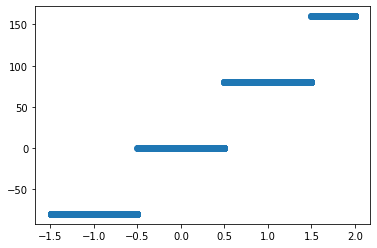

In [70]:
plt.scatter(X_stepsL_train,  Y_stepsL_train)
plt.show()

## Squares dataset visualization

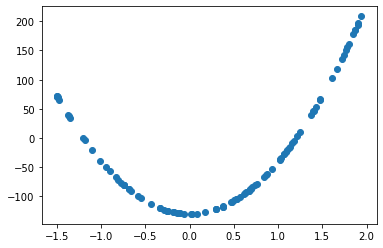

In [71]:
plt.scatter(X_squareS_train, Y_squareS_train)
plt.show()

## MLP for steps dataset (one hidden layer with 10 neurons)

### first attempt with random weights

In [72]:
mlp_steps = MLPNoBackprop(layer_sizes = [1, 10, 1])
y_stepsL_pred = mlp_steps.predict(X_stepsL_train)

In [73]:
mse_error_steps1 = mlp_steps.mse(Y_stepsL_train, y_stepsL_pred)
print(mse_error_steps1)

7100.4523024504215


In [74]:
print(y_stepsL_pred)

[[1.83207528]
 [4.00019317]
 [3.01619731]
 ...
 [3.8155419 ]
 [3.67163045]
 [3.74516189]]


### manually setting weights and biases

In [15]:
import ipywidgets as widgets
from ipywidgets import interactive

In [16]:
def update_plot(W_0_0, W_0_1, W_0_2, W_0_3, W_0_4, W_0_5, W_0_6, W_0_7, W_0_8, W_0_9,
                b_0_0, b_0_1, b_0_2, b_0_3, b_0_4, b_0_5, b_0_6, b_0_7, b_0_8, b_0_9,
                W_1_0, W_1_1, W_1_2, W_1_3, W_1_4, W_1_5, W_1_6, W_1_7, W_1_8, W_1_9,
                b_1):
    W_0 = np.array([[W_0_0, W_0_1, W_0_2, W_0_3, W_0_4, W_0_5, W_0_6, W_0_7, W_0_8, W_0_9]])
    b_0 = np.array([b_0_0, b_0_1, b_0_2, b_0_3, b_0_4, b_0_5, b_0_6, b_0_7, b_0_8, b_0_9])
    W_1 = np.array([[W_1_0], [W_1_1], [W_1_2], [W_1_3], [W_1_4], [W_1_5], [W_1_6], [W_1_7], [W_1_8], [W_1_9]])
    b_1 = np.array([b_1])

    mlp_steps.set_weights_and_biases(0, W_0, b_0)
    mlp_steps.set_weights_and_biases(1, W_1, b_1)


    y_stepsL_pred = mlp_steps.predict(X_stepsL_train)
    mse_value = mlp_steps.mse(Y_stepsL_train, y_stepsL_pred)

    plt.figure(figsize=(8, 5))
    plt.scatter(X_stepsL_train, Y_stepsL_train, label='True Data', color='blue', alpha=0.5)
    plt.scatter(X_stepsL_train, y_stepsL_pred, label=f'Predicted Data (MSE: {mse_value:.4f})', color='red')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Interactive MLP Regression')
    plt.show()


widgets_list = [
    widgets.FloatSlider(value=10, min=-600, max=600, step=0.1, description=f'W_0_{i}') for i in range(10)
] + [
    widgets.FloatSlider(value=0, min=-600, max=600, step=0.1, description=f'b_0_{i}') for i in range(10)
] + [
    widgets.FloatSlider(value=-10, min=-600, max=600, step=0.1, description=f'W_1_{i}') for i in range(10)
] + [
    widgets.FloatSlider(value=0, min=-600, max=600, step=0.1, description=f'b_1')
]

interactive_plot = interactive(update_plot, **{f'W_0_{i}': widgets_list[i] for i in range(10)} |
                                              {f'b_0_{i}': widgets_list[i+10] for i in range(10)} |
                                              {f'W_1_{i}': widgets_list[i+20] for i in range(10)} |
                                              {'b_1': widgets_list[30]})

interactive_plot

interactive(children=(FloatSlider(value=10.0, description='W_0_0', max=600.0, min=-600.0), FloatSlider(value=1…

## weights from sliders

In [17]:
W_0 = np.array([[300.3,501.1,472.5,600.0,500.1,399.9,403.6,463.9,500.0,500.0]])
b_0 = np.array([150.0,-250.5,-506.5,-306.1,-375.3,-600.0,-303.1,-346.5,-530.0,-536.1])
mlp_steps.set_weights_and_biases(0, W_0, b_0)

W_1 = np.array([[83.8],[85.7],[-25.9],[-10.4],[-33.6],[77.0],[25.8],[11.0],[-0.3],[28.2]])
b_1 = np.array([-82.0])
mlp_steps.set_weights_and_biases(1, W_1, b_1)

y_stepsL_pred =mlp_steps.predict(X_stepsL_train)
mse_value = mlp_steps.mse(Y_stepsL_train, y_stepsL_pred)
print(mse_value)

8.527777568129963


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22808\3951724984.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


## mse on training set

In [18]:
y_stepsL_pred =mlp_steps.predict(X_stepsL_test)
mse_value = mlp_steps.mse(Y_stepsL_test, y_stepsL_pred)
print(mse_value)

7.507656780160088


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22808\3951724984.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


# MLP for squares dataset(one hidden layer with 5 neurons)

## random weights

In [19]:
mlp_square= MLPNoBackprop(layer_sizes = [1,5,1], hidden_activation='relu')
y_squareS_pred = mlp_square.predict(X_squareS_train)

In [20]:
mse_error_square1 = mlp_square.mse(Y_squareS_train, y_squareS_pred)
print(mse_error_square1)

10044.097081377582


## silders for weights and biases manipulation

In [21]:
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [22]:
def update_plot(W_0_0, W_0_1, W_0_2, W_0_3, W_0_4,
                b_0_0, b_0_1, b_0_2, b_0_3, b_0_4,
                W_1_0, W_1_1, W_1_2, W_1_3, W_1_4,
                b_1):

    W_0 = np.array([[W_0_0, W_0_1, W_0_2, W_0_3, W_0_4]])
    b_0 = np.array([b_0_0, b_0_1, b_0_2, b_0_3, b_0_4])
    W_1 = np.array([[W_1_0], [W_1_1], [W_1_2], [W_1_3], [W_1_4]])
    b_1 = np.array([b_1])

   
    mlp_square.set_weights_and_biases(0, W_0, b_0)
    mlp_square.set_weights_and_biases(1, W_1, b_1)


    y_squareS_pred = mlp_square.predict(X_squareS_train)
    mse_value = mlp_square.mse(Y_squareS_train, y_squareS_pred)

   
    plt.figure(figsize=(8, 5))
    plt.scatter(X_squareS_train, Y_squareS_train, label='True Data', color='blue', alpha=0.5)
    plt.scatter(X_squareS_train, y_squareS_pred, label=f'Predicted Data (MSE: {mse_value:.4f})', color='red')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Interactive MLP Regression for Square')
    plt.show()


widgets_list = [
    widgets.FloatSlider(value=10, min=-600, max=600, step=0.1, description=f'W_0_{i}') for i in range(5)
] + [
    widgets.FloatSlider(value=0, min=-600, max=600, step=0.1, description=f'b_0_{i}') for i in range(5)
] + [
    widgets.FloatSlider(value=-10, min=-600, max=600, step=0.1, description=f'W_1_{i}') for i in range(5)
] + [
    widgets.FloatSlider(value=0, min=-600, max=600, step=0.1, description='b_1')
]


interactive_plot = interactive(update_plot, **{f'W_0_{i}': widgets_list[i] for i in range(5)} |
                                              {f'b_0_{i}': widgets_list[i+5] for i in range(5)} |
                                              {f'W_1_{i}': widgets_list[i+10] for i in range(5)} |
                                              {'b_1': widgets_list[15]})

interactive_plot


interactive(children=(FloatSlider(value=10.0, description='W_0_0', max=600.0, min=-600.0), FloatSlider(value=1…

In [23]:
W_0 = np.array([[297,41,-204,9.9,-121]])
b_0 = np.array([30, 0.02, -97.8, 0.3,13])
mlp_square.set_weights_and_biases(0, W_0, b_0)

W_1 = np.array([[0.11],[64.14],[0.96],[-251.3],[-0.13]])
b_1 = np.array([-113])
mlp_square.set_weights_and_biases(1, W_1, b_1)

y_squareS_pred =mlp_square.predict(X_squareS_train)
mse_value = mlp_square.mse(Y_squareS_train, y_squareS_pred)
print(mse_value)

479.7992090448728


### now on test set

In [24]:
y_pred = mlp_square.predict(X_squareS_test)
mse = mlp_square.mse(Y_squareS_test, y_pred)
print(mse)

415.87483547679824


# ------------------------------------------NN2------------------------------------------------------

Now we are working on this datastets: square-simple, steps-small, multimodal-large  
I have to implement backpropagation  
The squares set has already been loaded  
X_squareS_train = np.array(squareS_train[['x']])  
Y_squareS_train = np.array(squareS_train[['y']])  
X_squareS_test = np.array(squareS_test[['x']])  
Y_squareS_test = np.array(squareS_test[['y']])  
  
Let's load steps and multimodal dataset

In [6]:
stepsS_train = pd.read_csv('steps-small-training.csv')
stepsS_test = pd.read_csv('steps-small-test.csv')
multimodalL_train = pd.read_csv('multimodal-large-training.csv')
multimodalL_test = pd.read_csv('multimodal-large-test.csv')

### spliting into target and features

In [7]:
X_stepsS_train = np.array(stepsS_train[['x']])
Y_stepsS_train = np.array(stepsS_train[['y']])
X_stepsS_test = np.array(stepsS_test[['x']])
Y_stepsS_test = np.array(stepsS_test[['y']])
X_multimodalL_train = np.array(multimodalL_train[['x']])
Y_multimodalL_train = np.array(multimodalL_train[['y']])
X_multimodalL_test = np.array(multimodalL_test[['x']])
Y_multimodalL_test = np.array(multimodalL_test[['y']])

### now lets normalize our data

#### squares

In [8]:
X_squareS_train_normalized = (X_squareS_train- np.mean(X_squareS_train))/(np.std(X_squareS_train))
Y_squareS_train_normalized = (Y_squareS_train- np.mean(Y_squareS_train))/(np.std(Y_squareS_train))
X_squareS_test_normalized = (X_squareS_test- np.mean(X_squareS_train))/(np.std(X_squareS_train))
Y_squareS_test_normalized = (Y_squareS_test- np.mean(Y_squareS_train))/(np.std(Y_squareS_train))

#### steps

In [9]:
X_stepsS_train_normalized = (X_stepsS_train- np.mean(X_stepsS_train))/(np.std(X_stepsS_train))
Y_stepsS_train_normalized = (Y_stepsS_train- np.mean(Y_stepsS_train))/(np.std(Y_stepsS_train))
X_stepsS_test_normalized = (X_stepsS_test- np.mean(X_stepsS_train))/(np.std(X_stepsS_train))
Y_stepsS_test_normalized = (Y_stepsS_test- np.mean(Y_stepsS_train))/(np.std(Y_stepsS_train))

### multimodal

In [10]:
X_multimodalL_train_normalized = (X_multimodalL_train- np.mean(X_multimodalL_train))/(np.std(X_multimodalL_train))
Y_multimodalL_train_normalized = (Y_multimodalL_train- np.mean(Y_multimodalL_train))/(np.std(Y_multimodalL_train))
X_multimodalL_test_normalized = (X_multimodalL_test- np.mean(X_multimodalL_train))/(np.std(X_multimodalL_train))
Y_multimodalL_test_normalized = (Y_multimodalL_test- np.mean(Y_multimodalL_train))/(np.std(Y_multimodalL_train))

# MLP FOR SQUARES


## SGD


In [31]:
mlp_squares = MLPNoBackprop(layer_sizes = [1, 5, 5, 1])
start_time = time.time()
mlp_squares.SGD(X_squareS_train_normalized, Y_squareS_train_normalized, 10000, 0.05)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Czas wykonania: 387.783271 sekundy


In [32]:
Ypred_normalized = mlp_squares.predict(X_squareS_test_normalized)
Ypred = (Ypred_normalized * np.std(Y_squareS_train)) + np.mean(Y_squareS_train)
print(mlp_squares.mse(Ypred, Y_squareS_test))

0.08657051246166983


## mini batch

In [33]:
mlp_squares2 = MLPNoBackprop(layer_sizes = [1, 5, 5, 1])
start_time = time.time()
mlp_squares2.mini_batch_GD(X_squareS_train_normalized, Y_squareS_train_normalized, 5, 10000, 0.05)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Czas wykonania: 68.477309 sekundy


In [164]:
Ypred_normalized2 = mlp_squares2.predict(X_squareS_test_normalized)
Ypred2 = (Ypred_normalized2 * np.std(Y_squareS_train)) + np.mean(Y_squareS_train)
print(mlp_squares2.mse(Ypred2, Y_squareS_test))

0.2430205529022203


### lepszy wynik dla SGD ale dużo dłuższy czas wykonywania

# MLP FOR STEPS

## SGD 

In [165]:
mlp_steps = MLPNoBackprop(layer_sizes = [1, 10, 10, 1], weights_initialize_function ='uniform')
start_time = time.time()
mlp_steps.SGD(X_stepsS_train_normalized, Y_stepsS_train_normalized, 55000, 0.015)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Czas wykonania: 393.438124 sekundy


In [166]:
Ypred_normalized = mlp_steps.predict(X_stepsS_train_normalized)
Ypred = (Ypred_normalized * np.std(Y_stepsS_train)) + np.mean(Y_stepsS_train)
mse_value = mlp_steps.mse(Ypred, Y_stepsS_train)
print(mse_value)

3.560564624776615


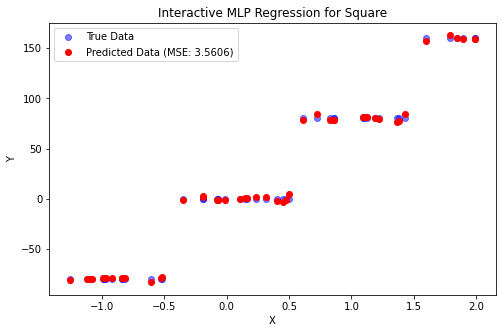

In [167]:
plt.figure(figsize=(8, 5))
plt.scatter(X_stepsS_train, Y_stepsS_train, label='True Data', color='blue', alpha=0.5)
plt.scatter(X_stepsS_train, Ypred, label=f'Predicted Data (MSE: {mse_value:.4f})', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interactive MLP Regression for Square')
plt.show()

## mini batch

In [172]:
mlp_steps2 = MLPNoBackprop(layer_sizes = [1, 10, 10, 1])
start_time = time.time()
mlp_steps2.mini_batch_GD(X_stepsS_train_normalized, Y_stepsS_train_normalized, 4, 52000, 0.06)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Czas wykonania: 62.462466 sekundy


In [173]:
Ypred_normalized2 = mlp_steps2.predict(X_stepsS_train_normalized)
Ypred2 = (Ypred_normalized2 * np.std(Y_stepsS_train)) + np.mean(Y_stepsS_train)
mse_value = mlp_steps2.mse(Ypred2, Y_stepsS_train)
print(mse_value) 

1.5753910567929217


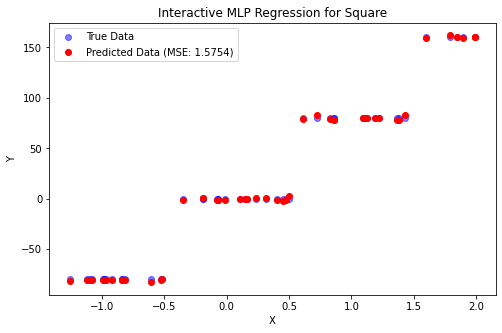

In [174]:
plt.figure(figsize=(8, 5))
plt.scatter(X_stepsS_train, Y_stepsS_train, label='True Data', color='blue', alpha=0.5)
plt.scatter(X_stepsS_train, Ypred2, label=f'Predicted Data (MSE: {mse_value:.4f})', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interactive MLP Regression for Square')
plt.show()

# MLP FOR MULTIMODAL

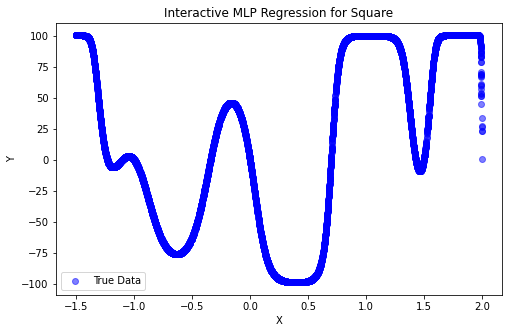

In [175]:
plt.figure(figsize=(8, 5))
plt.scatter(X_multimodalL_train, Y_multimodalL_train, label='True Data', color='blue', alpha=0.5)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interactive MLP Regression for Square')
plt.show()

In [187]:
mlp_multimodal = MLPNoBackprop(layer_sizes = [1, 26, 1], hidden_activation='tanh')
start_time = time.time()
mlp_multimodal.SGD(X_multimodalL_train_normalized, Y_multimodalL_train_normalized, 100, 0.01)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Czas wykonania: 44460.318400 sekundy


In [188]:
Ypred_normalized = mlp_multimodal.predict(X_multimodalL_test_normalized)
Ypred = (Ypred_normalized * np.std(Y_multimodalL_train)) + np.mean(Y_multimodalL_train)
print(mlp_steps.mse(Ypred, Y_multimodalL_test))

66.56316593008948


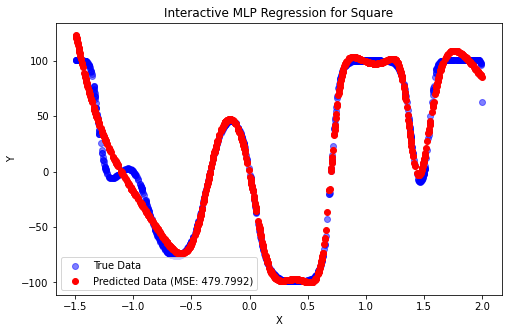

In [219]:
plt.figure(figsize=(8, 5))
plt.scatter(X_multimodalL_test, Y_multimodalL_test, label='True Data', color='blue', alpha=0.5)
plt.scatter(X_multimodalL_test, Ypred, label=f'Predicted Data (MSE: {mse_value:.4f})', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interactive MLP Regression for Square')
plt.show()

In [184]:
mlp_multimodal2 = MLPNoBackprop(layer_sizes = [1, 26, 1], hidden_activation='tanh')
start_time = time.time()
mlp_multimodal2.mini_batch_GD(X_multimodalL_train_normalized, Y_multimodalL_train_normalized, 10, 13000, 0.001)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Czas wykonania: 828.908015 sekundy


In [185]:
Ypred_normalized2 = mlp_multimodal2.predict(X_multimodalL_test_normalized)
Ypred2 = (Ypred_normalized2 * np.std(Y_multimodalL_train)) + np.mean(Y_multimodalL_train)
print(mlp_steps.mse(Ypred2, Y_multimodalL_test))

22.46038932023373


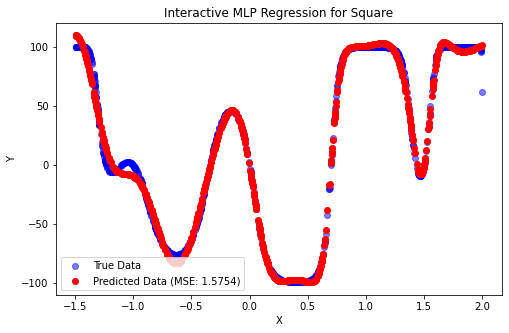

In [186]:
plt.figure(figsize=(8, 5))
plt.scatter(X_multimodalL_test, Y_multimodalL_test, label='True Data', color='blue', alpha=0.5)
plt.scatter(X_multimodalL_test, Ypred2, label=f'Predicted Data (MSE: {mse_value:.4f})', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interactive MLP Regression for Square')
plt.show()

# ----------------------------------------NN3--------------------------------------------------

### Now I have to implement two improvements to gradient-based learning: Momentum and gradient normalization using RMSprop I will be working on these datasets: square-large, steps-large and multimodal-large   Steps-large and Multimodal-Large have been already loaded. 


stepsL_train = pd.read_csv('steps-large-training.csv')  
stepsL_test = pd.read_csv('steps-large-test.csv')  
X_stepsL_train = np.array(stepsL_train[['x']])  
Y_stepsL_train = np.array(stepsL_train[['y']])  
X_stepsL_test = np.array(stepsL_test[['x']])  
Y_stepsL_test = np.array(stepsL_test[['y']])  
  
  
multimodalL_train = pd.read_csv('multimodal-large-training.csv')  
multimodalL_test = pd.read_csv('multimodal-large-test.csv')  
X_multimodalL_train = np.array(multimodalL_train[['x']])  
Y_multimodalL_train = np.array(multimodalL_train[['y']])  
X_multimodalL_test = np.array(multimodalL_test[['x']])  
Y_multimodalL_test = np.array(multimodalL_test[['y']])  
  
### multimodal-large have been additionaly normalised
X_multimodalL_train_normalized = (X_multimodalL_train-   np.mean(X_multimodalL_train))/(np.std(X_multimodalL_train))  
Y_multimodalL_train_normalized = (Y_multimodalL_train-   np.mean(Y_multimodalL_train))/(np.std(Y_multimodalL_train))  
X_multimodalL_test_normalized = (X_multimodalL_test-   np.mean(X_multimodalL_train))/(np.std(X_multimodalL_train))  
Y_multimodalL_test_normalized = (Y_multimodalL_test-   np.mean(Y_multimodalL_train))/(np.std(Y_multimodalL_train))  

### now i have to load square-large dataset and normalize it, just like the steps-large dataset

In [11]:
squareL_train =pd.read_csv('square-large-training.csv')
squareL_test = pd.read_csv('square-large-test.csv')
X_squareL_train = np.array(squareL_train[['x']])
Y_squareL_train = np.array(squareL_train[['y']])
X_squareL_test = np.array(squareL_test[['x']])
Y_squareL_test =np.array(squareL_test[['y']])

### now lets normalize square-large and steps-large

#### square


In [12]:
X_squareL_train_normalized = (X_squareL_train- np.mean(X_squareL_train))/(np.std(X_squareL_train))
Y_squareL_train_normalized = (Y_squareL_train- np.mean(Y_squareL_train))/(np.std(Y_squareL_train))
X_squareL_test_normalized = (X_squareL_test- np.mean(X_squareL_train))/(np.std(X_squareL_train))
Y_squareL_test_normalized = (Y_squareL_test- np.mean(Y_squareL_train))/(np.std(Y_squareL_train))

#### steps

In [13]:
X_stepsL_train_normalized = (X_stepsL_train- np.mean(X_stepsL_train))/(np.std(X_stepsL_train))
Y_stepsL_train_normalized =(Y_stepsL_train - np.mean(Y_stepsL_train))/(np.std(Y_stepsL_train))
X_stepsL_test_normalized = (X_stepsL_test - np.mean(X_stepsL_train))/(np.std(X_stepsL_train))
Y_stepsL_test_normalized =(Y_stepsL_test - np.mean(Y_stepsL_train))/(np.std(Y_stepsL_train)) 

## MLP for square_large trained using sgd with momentum

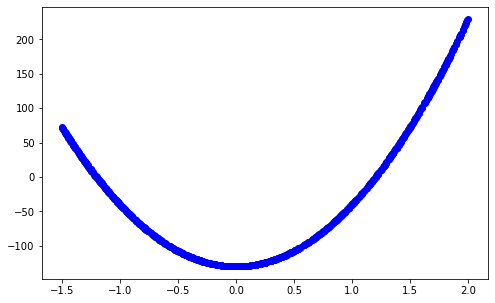

In [39]:
plt.figure(figsize=(8,5))
plt.scatter(X_squareL_train, Y_squareL_train, color='blue')

#### miało być sgd ale dałam batcha 10 bo strasznie długo się liczyło

## momentum

In [258]:
mlp_squareL = MLPNoBackprop(layer_sizes = [1, 15, 15, 1])
start_time = time.time()
mlp_squareL.momentum(X_squareL_train_normalized, Y_squareL_train_normalized, epochs = 30000, learning_rate=0.05, Lambda=0.9, batch_size=20)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Epoka 0: Loss = 0.448105630
Epoka 10: Loss = 0.006118061
Epoka 20: Loss = 0.001042717
Epoka 30: Loss = 0.000729126
Epoka 40: Loss = 0.000586496
Epoka 50: Loss = 0.000533271
Epoka 60: Loss = 0.000520248
Epoka 70: Loss = 0.000571519
Epoka 80: Loss = 0.000470262
Epoka 90: Loss = 0.000496940
Epoka 100: Loss = 0.000503969
Epoka 110: Loss = 0.000395058
Epoka 120: Loss = 0.000472663
Epoka 130: Loss = 0.000390923
Epoka 140: Loss = 0.000463588
Epoka 150: Loss = 0.000449806
Epoka 160: Loss = 0.000330962
Epoka 170: Loss = 0.000308071
Epoka 180: Loss = 0.000533593
Epoka 190: Loss = 0.000282947
Epoka 200: Loss = 0.000280253
Epoka 210: Loss = 0.000348157
Epoka 220: Loss = 0.000250085
Epoka 230: Loss = 0.000293016
Epoka 240: Loss = 0.000311509
Epoka 250: Loss = 0.000238481
Epoka 260: Loss = 0.000245946
Epoka 270: Loss = 0.000232444
Epoka 280: Loss = 0.000212785
Epoka 290: Loss = 0.000246781
Epoka 300: Loss = 0.000290005
Epoka 310: Loss = 0.000198222
Epoka 320: Loss = 0.000307868
Epoka 330: Loss = 0.0

Epoka 2690: Loss = 0.000004111
Epoka 2700: Loss = 0.000003704
Epoka 2710: Loss = 0.000002917
Epoka 2720: Loss = 0.000003228
Epoka 2730: Loss = 0.000003655
Epoka 2740: Loss = 0.000003264
Epoka 2750: Loss = 0.000003053
Epoka 2760: Loss = 0.000003686
Epoka 2770: Loss = 0.000002927
Epoka 2780: Loss = 0.000002863
Epoka 2790: Loss = 0.000002893
Epoka 2800: Loss = 0.000003142
Epoka 2810: Loss = 0.000003307
Epoka 2820: Loss = 0.000003305
Epoka 2830: Loss = 0.000003096
Epoka 2840: Loss = 0.000003213
Epoka 2850: Loss = 0.000002940
Epoka 2860: Loss = 0.000002717
Epoka 2870: Loss = 0.000003428
Epoka 2880: Loss = 0.000003041
Epoka 2890: Loss = 0.000004357
Epoka 2900: Loss = 0.000003025
Epoka 2910: Loss = 0.000004536
Epoka 2920: Loss = 0.000002892
Epoka 2930: Loss = 0.000004883
Epoka 2940: Loss = 0.000003970
Epoka 2950: Loss = 0.000003520
Epoka 2960: Loss = 0.000002782
Epoka 2970: Loss = 0.000004666
Epoka 2980: Loss = 0.000002642
Epoka 2990: Loss = 0.000003315
Epoka 3000: Loss = 0.000003094
Epoka 30

Epoka 5340: Loss = 0.000002165
Epoka 5350: Loss = 0.000001859
Epoka 5360: Loss = 0.000002248
Epoka 5370: Loss = 0.000005205
Epoka 5380: Loss = 0.000005218
Epoka 5390: Loss = 0.000001824
Epoka 5400: Loss = 0.000002064
Epoka 5410: Loss = 0.000001779
Epoka 5420: Loss = 0.000001993
Epoka 5430: Loss = 0.000003311
Epoka 5440: Loss = 0.000001725
Epoka 5450: Loss = 0.000002415
Epoka 5460: Loss = 0.000001996
Epoka 5470: Loss = 0.000001755
Epoka 5480: Loss = 0.000002064
Epoka 5490: Loss = 0.000002021
Epoka 5500: Loss = 0.000002341
Epoka 5510: Loss = 0.000002145
Epoka 5520: Loss = 0.000001705
Epoka 5530: Loss = 0.000002189
Epoka 5540: Loss = 0.000002200
Epoka 5550: Loss = 0.000002413
Epoka 5560: Loss = 0.000001821
Epoka 5570: Loss = 0.000001859
Epoka 5580: Loss = 0.000002358
Epoka 5590: Loss = 0.000002491
Epoka 5600: Loss = 0.000001677
Epoka 5610: Loss = 0.000001686
Epoka 5620: Loss = 0.000001776
Epoka 5630: Loss = 0.000002968
Epoka 5640: Loss = 0.000001784
Epoka 5650: Loss = 0.000001887
Epoka 56

Epoka 8000: Loss = 0.000001561
Epoka 8010: Loss = 0.000001917
Epoka 8020: Loss = 0.000001245
Epoka 8030: Loss = 0.000001725
Epoka 8040: Loss = 0.000001542
Epoka 8050: Loss = 0.000001297
Epoka 8060: Loss = 0.000001616
Epoka 8070: Loss = 0.000001325
Epoka 8080: Loss = 0.000001623
Epoka 8090: Loss = 0.000001749
Epoka 8100: Loss = 0.000003530
Epoka 8110: Loss = 0.000001733
Epoka 8120: Loss = 0.000001375
Epoka 8130: Loss = 0.000001352
Epoka 8140: Loss = 0.000001347
Epoka 8150: Loss = 0.000001207
Epoka 8160: Loss = 0.000001518
Epoka 8170: Loss = 0.000001212
Epoka 8180: Loss = 0.000001229
Epoka 8190: Loss = 0.000001366
Epoka 8200: Loss = 0.000001857
Epoka 8210: Loss = 0.000001248
Epoka 8220: Loss = 0.000001264
Epoka 8230: Loss = 0.000001276
Epoka 8240: Loss = 0.000001483
Epoka 8250: Loss = 0.000001345
Epoka 8260: Loss = 0.000001272
Epoka 8270: Loss = 0.000003124
Epoka 8280: Loss = 0.000001612
Epoka 8290: Loss = 0.000001273
Epoka 8300: Loss = 0.000001623
Epoka 8310: Loss = 0.000001612
Epoka 83

Epoka 10640: Loss = 0.000001217
Epoka 10650: Loss = 0.000001442
Epoka 10660: Loss = 0.000001173
Epoka 10670: Loss = 0.000001345
Epoka 10680: Loss = 0.000001030
Epoka 10690: Loss = 0.000001761
Epoka 10700: Loss = 0.000001431
Epoka 10710: Loss = 0.000001756
Epoka 10720: Loss = 0.000001154
Epoka 10730: Loss = 0.000001787
Epoka 10740: Loss = 0.000001069
Epoka 10750: Loss = 0.000003038
Epoka 10760: Loss = 0.000001617
Epoka 10770: Loss = 0.000001126
Epoka 10780: Loss = 0.000000936
Epoka 10790: Loss = 0.000001412
Epoka 10800: Loss = 0.000001329
Epoka 10810: Loss = 0.000001161
Epoka 10820: Loss = 0.000001010
Epoka 10830: Loss = 0.000000947
Epoka 10840: Loss = 0.000000981
Epoka 10850: Loss = 0.000001157
Epoka 10860: Loss = 0.000000918
Epoka 10870: Loss = 0.000001043
Epoka 10880: Loss = 0.000000968
Epoka 10890: Loss = 0.000001127
Epoka 10900: Loss = 0.000001384
Epoka 10910: Loss = 0.000001383
Epoka 10920: Loss = 0.000001077
Epoka 10930: Loss = 0.000000928
Epoka 10940: Loss = 0.000001131
Epoka 10

Epoka 13220: Loss = 0.000001144
Epoka 13230: Loss = 0.000000937
Epoka 13240: Loss = 0.000000790
Epoka 13250: Loss = 0.000001480
Epoka 13260: Loss = 0.000000906
Epoka 13270: Loss = 0.000001290
Epoka 13280: Loss = 0.000000843
Epoka 13290: Loss = 0.000000827
Epoka 13300: Loss = 0.000000811
Epoka 13310: Loss = 0.000000771
Epoka 13320: Loss = 0.000000951
Epoka 13330: Loss = 0.000000959
Epoka 13340: Loss = 0.000000747
Epoka 13350: Loss = 0.000000828
Epoka 13360: Loss = 0.000000744
Epoka 13370: Loss = 0.000000826
Epoka 13380: Loss = 0.000001028
Epoka 13390: Loss = 0.000001308
Epoka 13400: Loss = 0.000000870
Epoka 13410: Loss = 0.000001076
Epoka 13420: Loss = 0.000000810
Epoka 13430: Loss = 0.000000848
Epoka 13440: Loss = 0.000000725
Epoka 13450: Loss = 0.000000812
Epoka 13460: Loss = 0.000001111
Epoka 13470: Loss = 0.000001024
Epoka 13480: Loss = 0.000000800
Epoka 13490: Loss = 0.000000766
Epoka 13500: Loss = 0.000000799
Epoka 13510: Loss = 0.000000762
Epoka 13520: Loss = 0.000000764
Epoka 13

Epoka 15800: Loss = 0.000002126
Epoka 15810: Loss = 0.000000761
Epoka 15820: Loss = 0.000000625
Epoka 15830: Loss = 0.000000695
Epoka 15840: Loss = 0.000000858
Epoka 15850: Loss = 0.000000730
Epoka 15860: Loss = 0.000000643
Epoka 15870: Loss = 0.000000752
Epoka 15880: Loss = 0.000001294
Epoka 15890: Loss = 0.000000756
Epoka 15900: Loss = 0.000000825
Epoka 15910: Loss = 0.000000818
Epoka 15920: Loss = 0.000000630
Epoka 15930: Loss = 0.000000741
Epoka 15940: Loss = 0.000000645
Epoka 15950: Loss = 0.000001318
Epoka 15960: Loss = 0.000001259
Epoka 15970: Loss = 0.000000975
Epoka 15980: Loss = 0.000001317
Epoka 15990: Loss = 0.000000676
Epoka 16000: Loss = 0.000000643
Epoka 16010: Loss = 0.000001053
Epoka 16020: Loss = 0.000000693
Epoka 16030: Loss = 0.000000790
Epoka 16040: Loss = 0.000001427
Epoka 16050: Loss = 0.000000651
Epoka 16060: Loss = 0.000000687
Epoka 16070: Loss = 0.000000619
Epoka 16080: Loss = 0.000000786
Epoka 16090: Loss = 0.000000871
Epoka 16100: Loss = 0.000000695
Epoka 16

Epoka 18370: Loss = 0.000000527
Epoka 18380: Loss = 0.000000545
Epoka 18390: Loss = 0.000000608
Epoka 18400: Loss = 0.000000554
Epoka 18410: Loss = 0.000000633
Epoka 18420: Loss = 0.000000641
Epoka 18430: Loss = 0.000000519
Epoka 18440: Loss = 0.000000550
Epoka 18450: Loss = 0.000000826
Epoka 18460: Loss = 0.000000748
Epoka 18470: Loss = 0.000000569
Epoka 18480: Loss = 0.000000532
Epoka 18490: Loss = 0.000000511
Epoka 18500: Loss = 0.000000577
Epoka 18510: Loss = 0.000000547
Epoka 18520: Loss = 0.000000606
Epoka 18530: Loss = 0.000000656
Epoka 18540: Loss = 0.000001160
Epoka 18550: Loss = 0.000000585
Epoka 18560: Loss = 0.000000680
Epoka 18570: Loss = 0.000000959
Epoka 18580: Loss = 0.000000548
Epoka 18590: Loss = 0.000000711
Epoka 18600: Loss = 0.000000535
Epoka 18610: Loss = 0.000000889
Epoka 18620: Loss = 0.000000521
Epoka 18630: Loss = 0.000000568
Epoka 18640: Loss = 0.000000600
Epoka 18650: Loss = 0.000000511
Epoka 18660: Loss = 0.000000766
Epoka 18670: Loss = 0.000000796
Epoka 18

Epoka 20950: Loss = 0.000000748
Epoka 20960: Loss = 0.000000458
Epoka 20970: Loss = 0.000000541
Epoka 20980: Loss = 0.000000684
Epoka 20990: Loss = 0.000000621
Epoka 21000: Loss = 0.000000499
Epoka 21010: Loss = 0.000000429
Epoka 21020: Loss = 0.000000809
Epoka 21030: Loss = 0.000000448
Epoka 21040: Loss = 0.000000443
Epoka 21050: Loss = 0.000000425
Epoka 21060: Loss = 0.000000550
Epoka 21070: Loss = 0.000000965
Epoka 21080: Loss = 0.000000578
Epoka 21090: Loss = 0.000000461
Epoka 21100: Loss = 0.000000520
Epoka 21110: Loss = 0.000000437
Epoka 21120: Loss = 0.000000456
Epoka 21130: Loss = 0.000000496
Epoka 21140: Loss = 0.000000413
Epoka 21150: Loss = 0.000000478
Epoka 21160: Loss = 0.000000491
Epoka 21170: Loss = 0.000000444
Epoka 21180: Loss = 0.000000423
Epoka 21190: Loss = 0.000000449
Epoka 21200: Loss = 0.000001000
Epoka 21210: Loss = 0.000000441
Epoka 21220: Loss = 0.000000650
Epoka 21230: Loss = 0.000000499
Epoka 21240: Loss = 0.000000804
Epoka 21250: Loss = 0.000001101
Epoka 21

Epoka 23540: Loss = 0.000000365
Epoka 23550: Loss = 0.000000517
Epoka 23560: Loss = 0.000000370
Epoka 23570: Loss = 0.000000477
Epoka 23580: Loss = 0.000000425
Epoka 23590: Loss = 0.000000546
Epoka 23600: Loss = 0.000000456
Epoka 23610: Loss = 0.000000405
Epoka 23620: Loss = 0.000000468
Epoka 23630: Loss = 0.000000602
Epoka 23640: Loss = 0.000000415
Epoka 23650: Loss = 0.000000341
Epoka 23660: Loss = 0.000000699
Epoka 23670: Loss = 0.000000361
Epoka 23680: Loss = 0.000000401
Epoka 23690: Loss = 0.000000390
Epoka 23700: Loss = 0.000000376
Epoka 23710: Loss = 0.000000391
Epoka 23720: Loss = 0.000000517
Epoka 23730: Loss = 0.000000354
Epoka 23740: Loss = 0.000001011
Epoka 23750: Loss = 0.000000458
Epoka 23760: Loss = 0.000000440
Epoka 23770: Loss = 0.000000340
Epoka 23780: Loss = 0.000000568
Epoka 23790: Loss = 0.000000372
Epoka 23800: Loss = 0.000000768
Epoka 23810: Loss = 0.000000650
Epoka 23820: Loss = 0.000000424
Epoka 23830: Loss = 0.000000475
Epoka 23840: Loss = 0.000000450
Epoka 23

Epoka 26110: Loss = 0.000000648
Epoka 26120: Loss = 0.000000337
Epoka 26130: Loss = 0.000000405
Epoka 26140: Loss = 0.000000333
Epoka 26150: Loss = 0.000000294
Epoka 26160: Loss = 0.000000651
Epoka 26170: Loss = 0.000000516
Epoka 26180: Loss = 0.000000554
Epoka 26190: Loss = 0.000000386
Epoka 26200: Loss = 0.000000296
Epoka 26210: Loss = 0.000000321
Epoka 26220: Loss = 0.000000328
Epoka 26230: Loss = 0.000000297
Epoka 26240: Loss = 0.000000494
Epoka 26250: Loss = 0.000000428
Epoka 26260: Loss = 0.000000726
Epoka 26270: Loss = 0.000000287
Epoka 26280: Loss = 0.000000298
Epoka 26290: Loss = 0.000000584
Epoka 26300: Loss = 0.000000333
Epoka 26310: Loss = 0.000000526
Epoka 26320: Loss = 0.000000327
Epoka 26330: Loss = 0.000000326
Epoka 26340: Loss = 0.000000426
Epoka 26350: Loss = 0.000000668
Epoka 26360: Loss = 0.000000302
Epoka 26370: Loss = 0.000000519
Epoka 26380: Loss = 0.000000639
Epoka 26390: Loss = 0.000000368
Epoka 26400: Loss = 0.000000352
Epoka 26410: Loss = 0.000000386
Epoka 26

Epoka 28700: Loss = 0.000000384
Epoka 28710: Loss = 0.000000285
Epoka 28720: Loss = 0.000000279
Epoka 28730: Loss = 0.000000476
Epoka 28740: Loss = 0.000000310
Epoka 28750: Loss = 0.000000269
Epoka 28760: Loss = 0.000000275
Epoka 28770: Loss = 0.000000261
Epoka 28780: Loss = 0.000000349
Epoka 28790: Loss = 0.000000254
Epoka 28800: Loss = 0.000000267
Epoka 28810: Loss = 0.000000282
Epoka 28820: Loss = 0.000000272
Epoka 28830: Loss = 0.000000316
Epoka 28840: Loss = 0.000000371
Epoka 28850: Loss = 0.000000324
Epoka 28860: Loss = 0.000000353
Epoka 28870: Loss = 0.000000270
Epoka 28880: Loss = 0.000000263
Epoka 28890: Loss = 0.000000243
Epoka 28900: Loss = 0.000000561
Epoka 28910: Loss = 0.000000342
Epoka 28920: Loss = 0.000000299
Epoka 28930: Loss = 0.000000253
Epoka 28940: Loss = 0.000000271
Epoka 28950: Loss = 0.000000271
Epoka 28960: Loss = 0.000000299
Epoka 28970: Loss = 0.000000336
Epoka 28980: Loss = 0.000000299
Epoka 28990: Loss = 0.000000256
Epoka 29000: Loss = 0.000000306
Epoka 29

In [268]:
ypred_normalized = mlp_squareL.predict(X_squareL_train_normalized)
ypred = ypred_normalized *np.std(Y_squareL_train) +np.mean(Y_squareL_train)
print(mlp_squareL.mse(ypred, Y_squareL_train))


0.0021961347516349906


In [259]:
ypred_normalized = mlp_squareL.predict(X_squareL_test_normalized)
ypred = ypred_normalized *np.std(Y_squareL_train) +np.mean(Y_squareL_train)
print(mlp_squareL.mse(ypred, Y_squareL_test))


5.372767564366863


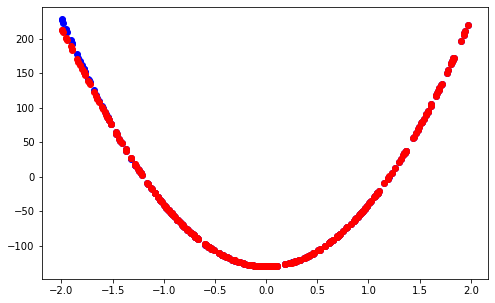

In [260]:
plt.figure(figsize=(8,5))
plt.scatter(X_squareL_test, Y_squareL_test, color='blue')
plt.scatter(X_squareL_test, ypred, color='red')

## RMSprop

In [327]:
mlp_squareL2 = MLPNoBackprop(layer_sizes = [1, 10, 1])
start_time = time.time()
mlp_squareL2.RMSprop(X_squareL_train_normalized, Y_squareL_train_normalized, epochs = 40000, learning_rate=0.001, beta=0.8, epsilon=1e-7, batch_size=32)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Epoka 0: Loss = 3.451318008
Epoka 10: Loss = 2.246149374
Epoka 20: Loss = 1.456686883
Epoka 30: Loss = 1.038661921
Epoka 40: Loss = 0.905552979
Epoka 50: Loss = 0.870637164
Epoka 60: Loss = 0.847226919
Epoka 70: Loss = 0.826416661
Epoka 80: Loss = 0.807997224
Epoka 90: Loss = 0.792321370
Epoka 100: Loss = 0.779026268
Epoka 110: Loss = 0.767585774
Epoka 120: Loss = 0.757112037
Epoka 130: Loss = 0.748016758
Epoka 140: Loss = 0.739814878
Epoka 150: Loss = 0.731733978
Epoka 160: Loss = 0.723874432
Epoka 170: Loss = 0.716039791
Epoka 180: Loss = 0.707957279
Epoka 190: Loss = 0.699680014
Epoka 200: Loss = 0.690955991
Epoka 210: Loss = 0.681780506
Epoka 220: Loss = 0.671963894
Epoka 230: Loss = 0.661948328
Epoka 240: Loss = 0.651207468
Epoka 250: Loss = 0.640116147
Epoka 260: Loss = 0.628624974
Epoka 270: Loss = 0.616051640
Epoka 280: Loss = 0.603034082
Epoka 290: Loss = 0.589598373
Epoka 300: Loss = 0.575757307
Epoka 310: Loss = 0.561118530
Epoka 320: Loss = 0.545686809
Epoka 330: Loss = 0.5

Epoka 2700: Loss = 0.000151410
Epoka 2710: Loss = 0.000149170
Epoka 2720: Loss = 0.000146476
Epoka 2730: Loss = 0.000149473
Epoka 2740: Loss = 0.000143152
Epoka 2750: Loss = 0.000139765
Epoka 2760: Loss = 0.000137468
Epoka 2770: Loss = 0.000136541
Epoka 2780: Loss = 0.000134726
Epoka 2790: Loss = 0.000135258
Epoka 2800: Loss = 0.000128322
Epoka 2810: Loss = 0.000125784
Epoka 2820: Loss = 0.000123456
Epoka 2830: Loss = 0.000121249
Epoka 2840: Loss = 0.000120477
Epoka 2850: Loss = 0.000118077
Epoka 2860: Loss = 0.000115513
Epoka 2870: Loss = 0.000112882
Epoka 2880: Loss = 0.000113748
Epoka 2890: Loss = 0.000108980
Epoka 2900: Loss = 0.000106898
Epoka 2910: Loss = 0.000104443
Epoka 2920: Loss = 0.000103715
Epoka 2930: Loss = 0.000100659
Epoka 2940: Loss = 0.000100266
Epoka 2950: Loss = 0.000096815
Epoka 2960: Loss = 0.000096513
Epoka 2970: Loss = 0.000093818
Epoka 2980: Loss = 0.000092932
Epoka 2990: Loss = 0.000091229
Epoka 3000: Loss = 0.000089946
Epoka 3010: Loss = 0.000086998
Epoka 30

Epoka 5380: Loss = 0.000019565
Epoka 5390: Loss = 0.000020402
Epoka 5400: Loss = 0.000019589
Epoka 5410: Loss = 0.000019894
Epoka 5420: Loss = 0.000020363
Epoka 5430: Loss = 0.000019977
Epoka 5440: Loss = 0.000019577
Epoka 5450: Loss = 0.000019546
Epoka 5460: Loss = 0.000019286
Epoka 5470: Loss = 0.000018979
Epoka 5480: Loss = 0.000020780
Epoka 5490: Loss = 0.000019006
Epoka 5500: Loss = 0.000019144
Epoka 5510: Loss = 0.000018895
Epoka 5520: Loss = 0.000018962
Epoka 5530: Loss = 0.000019582
Epoka 5540: Loss = 0.000021022
Epoka 5550: Loss = 0.000018770
Epoka 5560: Loss = 0.000018435
Epoka 5570: Loss = 0.000018569
Epoka 5580: Loss = 0.000018498
Epoka 5590: Loss = 0.000018429
Epoka 5600: Loss = 0.000018495
Epoka 5610: Loss = 0.000019650
Epoka 5620: Loss = 0.000019640
Epoka 5630: Loss = 0.000018339
Epoka 5640: Loss = 0.000018757
Epoka 5650: Loss = 0.000018427
Epoka 5660: Loss = 0.000018174
Epoka 5670: Loss = 0.000018954
Epoka 5680: Loss = 0.000018320
Epoka 5690: Loss = 0.000018106
Epoka 57

Epoka 8060: Loss = 0.000009772
Epoka 8070: Loss = 0.000011679
Epoka 8080: Loss = 0.000010117
Epoka 8090: Loss = 0.000011471
Epoka 8100: Loss = 0.000009668
Epoka 8110: Loss = 0.000009725
Epoka 8120: Loss = 0.000010215
Epoka 8130: Loss = 0.000009908
Epoka 8140: Loss = 0.000010829
Epoka 8150: Loss = 0.000009677
Epoka 8160: Loss = 0.000009859
Epoka 8170: Loss = 0.000009916
Epoka 8180: Loss = 0.000010351
Epoka 8190: Loss = 0.000009483
Epoka 8200: Loss = 0.000009650
Epoka 8210: Loss = 0.000009727
Epoka 8220: Loss = 0.000009595
Epoka 8230: Loss = 0.000010345
Epoka 8240: Loss = 0.000009547
Epoka 8250: Loss = 0.000009823
Epoka 8260: Loss = 0.000009956
Epoka 8270: Loss = 0.000012101
Epoka 8280: Loss = 0.000011891
Epoka 8290: Loss = 0.000009403
Epoka 8300: Loss = 0.000009595
Epoka 8310: Loss = 0.000009777
Epoka 8320: Loss = 0.000010143
Epoka 8330: Loss = 0.000009382
Epoka 8340: Loss = 0.000009868
Epoka 8350: Loss = 0.000009819
Epoka 8360: Loss = 0.000009398
Epoka 8370: Loss = 0.000009448
Epoka 83

Epoka 10710: Loss = 0.000006419
Epoka 10720: Loss = 0.000007059
Epoka 10730: Loss = 0.000005936
Epoka 10740: Loss = 0.000005887
Epoka 10750: Loss = 0.000005692
Epoka 10760: Loss = 0.000006250
Epoka 10770: Loss = 0.000006446
Epoka 10780: Loss = 0.000006059
Epoka 10790: Loss = 0.000005934
Epoka 10800: Loss = 0.000006665
Epoka 10810: Loss = 0.000005829
Epoka 10820: Loss = 0.000006429
Epoka 10830: Loss = 0.000005633
Epoka 10840: Loss = 0.000005755
Epoka 10850: Loss = 0.000005808
Epoka 10860: Loss = 0.000005833
Epoka 10870: Loss = 0.000006551
Epoka 10880: Loss = 0.000005547
Epoka 10890: Loss = 0.000005530
Epoka 10900: Loss = 0.000006139
Epoka 10910: Loss = 0.000005910
Epoka 10920: Loss = 0.000005543
Epoka 10930: Loss = 0.000005507
Epoka 10940: Loss = 0.000006864
Epoka 10950: Loss = 0.000006834
Epoka 10960: Loss = 0.000005616
Epoka 10970: Loss = 0.000006165
Epoka 10980: Loss = 0.000005728
Epoka 10990: Loss = 0.000006567
Epoka 11000: Loss = 0.000005838
Epoka 11010: Loss = 0.000006471
Epoka 11

Epoka 13300: Loss = 0.000003839
Epoka 13310: Loss = 0.000004801
Epoka 13320: Loss = 0.000004005
Epoka 13330: Loss = 0.000004286
Epoka 13340: Loss = 0.000003937
Epoka 13350: Loss = 0.000004157
Epoka 13360: Loss = 0.000003738
Epoka 13370: Loss = 0.000004153
Epoka 13380: Loss = 0.000004712
Epoka 13390: Loss = 0.000004015
Epoka 13400: Loss = 0.000003845
Epoka 13410: Loss = 0.000004151
Epoka 13420: Loss = 0.000003768
Epoka 13430: Loss = 0.000004558
Epoka 13440: Loss = 0.000003735
Epoka 13450: Loss = 0.000003902
Epoka 13460: Loss = 0.000003648
Epoka 13470: Loss = 0.000004141
Epoka 13480: Loss = 0.000003920
Epoka 13490: Loss = 0.000003635
Epoka 13500: Loss = 0.000004142
Epoka 13510: Loss = 0.000003613
Epoka 13520: Loss = 0.000003809
Epoka 13530: Loss = 0.000003562
Epoka 13540: Loss = 0.000003504
Epoka 13550: Loss = 0.000003592
Epoka 13560: Loss = 0.000003506
Epoka 13570: Loss = 0.000004193
Epoka 13580: Loss = 0.000003810
Epoka 13590: Loss = 0.000003762
Epoka 13600: Loss = 0.000004037
Epoka 13

Epoka 15900: Loss = 0.000002609
Epoka 15910: Loss = 0.000002672
Epoka 15920: Loss = 0.000002651
Epoka 15930: Loss = 0.000002688
Epoka 15940: Loss = 0.000002861
Epoka 15950: Loss = 0.000002887
Epoka 15960: Loss = 0.000002608
Epoka 15970: Loss = 0.000002732
Epoka 15980: Loss = 0.000004784
Epoka 15990: Loss = 0.000003099
Epoka 16000: Loss = 0.000002827
Epoka 16010: Loss = 0.000002556
Epoka 16020: Loss = 0.000003069
Epoka 16030: Loss = 0.000002708
Epoka 16040: Loss = 0.000002822
Epoka 16050: Loss = 0.000002916
Epoka 16060: Loss = 0.000003136
Epoka 16070: Loss = 0.000002617
Epoka 16080: Loss = 0.000002576
Epoka 16090: Loss = 0.000002956
Epoka 16100: Loss = 0.000002514
Epoka 16110: Loss = 0.000002726
Epoka 16120: Loss = 0.000003275
Epoka 16130: Loss = 0.000002945
Epoka 16140: Loss = 0.000003146
Epoka 16150: Loss = 0.000003040
Epoka 16160: Loss = 0.000003586
Epoka 16170: Loss = 0.000003187
Epoka 16180: Loss = 0.000002450
Epoka 16190: Loss = 0.000002525
Epoka 16200: Loss = 0.000002701
Epoka 16

Epoka 18470: Loss = 0.000001932
Epoka 18480: Loss = 0.000002524
Epoka 18490: Loss = 0.000002045
Epoka 18500: Loss = 0.000002089
Epoka 18510: Loss = 0.000002113
Epoka 18520: Loss = 0.000002106
Epoka 18530: Loss = 0.000001955
Epoka 18540: Loss = 0.000001987
Epoka 18550: Loss = 0.000001917
Epoka 18560: Loss = 0.000002230
Epoka 18570: Loss = 0.000002052
Epoka 18580: Loss = 0.000001953
Epoka 18590: Loss = 0.000001781
Epoka 18600: Loss = 0.000002129
Epoka 18610: Loss = 0.000002106
Epoka 18620: Loss = 0.000002103
Epoka 18630: Loss = 0.000002070
Epoka 18640: Loss = 0.000002171
Epoka 18650: Loss = 0.000002786
Epoka 18660: Loss = 0.000001896
Epoka 18670: Loss = 0.000002523
Epoka 18680: Loss = 0.000002553
Epoka 18690: Loss = 0.000001800
Epoka 18700: Loss = 0.000001810
Epoka 18710: Loss = 0.000002263
Epoka 18720: Loss = 0.000002000
Epoka 18730: Loss = 0.000002352
Epoka 18740: Loss = 0.000001979
Epoka 18750: Loss = 0.000002684
Epoka 18760: Loss = 0.000002550
Epoka 18770: Loss = 0.000001985
Epoka 18

Epoka 21070: Loss = 0.000001411
Epoka 21080: Loss = 0.000001733
Epoka 21090: Loss = 0.000001518
Epoka 21100: Loss = 0.000001414
Epoka 21110: Loss = 0.000001585
Epoka 21120: Loss = 0.000002288
Epoka 21130: Loss = 0.000001354
Epoka 21140: Loss = 0.000003274
Epoka 21150: Loss = 0.000001686
Epoka 21160: Loss = 0.000001364
Epoka 21170: Loss = 0.000002271
Epoka 21180: Loss = 0.000001786
Epoka 21190: Loss = 0.000001512
Epoka 21200: Loss = 0.000001423
Epoka 21210: Loss = 0.000001352
Epoka 21220: Loss = 0.000001375
Epoka 21230: Loss = 0.000001448
Epoka 21240: Loss = 0.000001695
Epoka 21250: Loss = 0.000001596
Epoka 21260: Loss = 0.000001378
Epoka 21270: Loss = 0.000001631
Epoka 21280: Loss = 0.000001423
Epoka 21290: Loss = 0.000001428
Epoka 21300: Loss = 0.000001352
Epoka 21310: Loss = 0.000001326
Epoka 21320: Loss = 0.000002148
Epoka 21330: Loss = 0.000002245
Epoka 21340: Loss = 0.000001794
Epoka 21350: Loss = 0.000001454
Epoka 21360: Loss = 0.000001848
Epoka 21370: Loss = 0.000001520
Epoka 21

Epoka 23650: Loss = 0.000001391
Epoka 23660: Loss = 0.000001080
Epoka 23670: Loss = 0.000001231
Epoka 23680: Loss = 0.000001100
Epoka 23690: Loss = 0.000001364
Epoka 23700: Loss = 0.000002230
Epoka 23710: Loss = 0.000001044
Epoka 23720: Loss = 0.000001140
Epoka 23730: Loss = 0.000001152
Epoka 23740: Loss = 0.000001300
Epoka 23750: Loss = 0.000001290
Epoka 23760: Loss = 0.000001108
Epoka 23770: Loss = 0.000001331
Epoka 23780: Loss = 0.000001257
Epoka 23790: Loss = 0.000001295
Epoka 23800: Loss = 0.000001270
Epoka 23810: Loss = 0.000001044
Epoka 23820: Loss = 0.000001166
Epoka 23830: Loss = 0.000001138
Epoka 23840: Loss = 0.000001131
Epoka 23850: Loss = 0.000001289
Epoka 23860: Loss = 0.000001175
Epoka 23870: Loss = 0.000001084
Epoka 23880: Loss = 0.000001225
Epoka 23890: Loss = 0.000001048
Epoka 23900: Loss = 0.000001059
Epoka 23910: Loss = 0.000001384
Epoka 23920: Loss = 0.000001204
Epoka 23930: Loss = 0.000001479
Epoka 23940: Loss = 0.000001599
Epoka 23950: Loss = 0.000001172
Epoka 23

Epoka 26230: Loss = 0.000000866
Epoka 26240: Loss = 0.000001167
Epoka 26250: Loss = 0.000001100
Epoka 26260: Loss = 0.000001077
Epoka 26270: Loss = 0.000001636
Epoka 26280: Loss = 0.000000981
Epoka 26290: Loss = 0.000001882
Epoka 26300: Loss = 0.000001371
Epoka 26310: Loss = 0.000000861
Epoka 26320: Loss = 0.000001041
Epoka 26330: Loss = 0.000000924
Epoka 26340: Loss = 0.000000832
Epoka 26350: Loss = 0.000001205
Epoka 26360: Loss = 0.000000957
Epoka 26370: Loss = 0.000000867
Epoka 26380: Loss = 0.000001024
Epoka 26390: Loss = 0.000001264
Epoka 26400: Loss = 0.000001113
Epoka 26410: Loss = 0.000001266
Epoka 26420: Loss = 0.000000970
Epoka 26430: Loss = 0.000001268
Epoka 26440: Loss = 0.000000857
Epoka 26450: Loss = 0.000000931
Epoka 26460: Loss = 0.000001153
Epoka 26470: Loss = 0.000000833
Epoka 26480: Loss = 0.000000897
Epoka 26490: Loss = 0.000000933
Epoka 26500: Loss = 0.000001003
Epoka 26510: Loss = 0.000002934
Epoka 26520: Loss = 0.000001637
Epoka 26530: Loss = 0.000000863
Epoka 26

Epoka 28810: Loss = 0.000001120
Epoka 28820: Loss = 0.000001020
Epoka 28830: Loss = 0.000001701
Epoka 28840: Loss = 0.000000768
Epoka 28850: Loss = 0.000000756
Epoka 28860: Loss = 0.000000946
Epoka 28870: Loss = 0.000000752
Epoka 28880: Loss = 0.000001291
Epoka 28890: Loss = 0.000001137
Epoka 28900: Loss = 0.000000975
Epoka 28910: Loss = 0.000000929
Epoka 28920: Loss = 0.000000894
Epoka 28930: Loss = 0.000001233
Epoka 28940: Loss = 0.000000766
Epoka 28950: Loss = 0.000000682
Epoka 28960: Loss = 0.000000736
Epoka 28970: Loss = 0.000001016
Epoka 28980: Loss = 0.000000692
Epoka 28990: Loss = 0.000000699
Epoka 29000: Loss = 0.000000714
Epoka 29010: Loss = 0.000000738
Epoka 29020: Loss = 0.000000777
Epoka 29030: Loss = 0.000000681
Epoka 29040: Loss = 0.000000693
Epoka 29050: Loss = 0.000001211
Epoka 29060: Loss = 0.000000945
Epoka 29070: Loss = 0.000001872
Epoka 29080: Loss = 0.000000687
Epoka 29090: Loss = 0.000001283
Epoka 29100: Loss = 0.000000839
Epoka 29110: Loss = 0.000000790
Epoka 29

Epoka 31390: Loss = 0.000000842
Epoka 31400: Loss = 0.000001458
Epoka 31410: Loss = 0.000000656
Epoka 31420: Loss = 0.000001082
Epoka 31430: Loss = 0.000000761
Epoka 31440: Loss = 0.000000608
Epoka 31450: Loss = 0.000001141
Epoka 31460: Loss = 0.000000674
Epoka 31470: Loss = 0.000000934
Epoka 31480: Loss = 0.000000797
Epoka 31490: Loss = 0.000000662
Epoka 31500: Loss = 0.000001265
Epoka 31510: Loss = 0.000000599
Epoka 31520: Loss = 0.000000983
Epoka 31530: Loss = 0.000001324
Epoka 31540: Loss = 0.000000979
Epoka 31550: Loss = 0.000000766
Epoka 31560: Loss = 0.000001349
Epoka 31570: Loss = 0.000000696
Epoka 31580: Loss = 0.000000658
Epoka 31590: Loss = 0.000000658
Epoka 31600: Loss = 0.000000878
Epoka 31610: Loss = 0.000000879
Epoka 31620: Loss = 0.000000748
Epoka 31630: Loss = 0.000000599
Epoka 31640: Loss = 0.000000637
Epoka 31650: Loss = 0.000000652
Epoka 31660: Loss = 0.000000617
Epoka 31670: Loss = 0.000000922
Epoka 31680: Loss = 0.000000613
Epoka 31690: Loss = 0.000000762
Epoka 31

Epoka 33960: Loss = 0.000000610
Epoka 33970: Loss = 0.000000648
Epoka 33980: Loss = 0.000000959
Epoka 33990: Loss = 0.000000532
Epoka 34000: Loss = 0.000000796
Epoka 34010: Loss = 0.000000524
Epoka 34020: Loss = 0.000000582
Epoka 34030: Loss = 0.000000650
Epoka 34040: Loss = 0.000000564
Epoka 34050: Loss = 0.000000548
Epoka 34060: Loss = 0.000000765
Epoka 34070: Loss = 0.000000879
Epoka 34080: Loss = 0.000000666
Epoka 34090: Loss = 0.000000562
Epoka 34100: Loss = 0.000000650
Epoka 34110: Loss = 0.000000634
Epoka 34120: Loss = 0.000000715
Epoka 34130: Loss = 0.000000595
Epoka 34140: Loss = 0.000000621
Epoka 34150: Loss = 0.000001378
Epoka 34160: Loss = 0.000001346
Epoka 34170: Loss = 0.000000931
Epoka 34180: Loss = 0.000000728
Epoka 34190: Loss = 0.000000634
Epoka 34200: Loss = 0.000000617
Epoka 34210: Loss = 0.000000701
Epoka 34220: Loss = 0.000000565
Epoka 34230: Loss = 0.000000689
Epoka 34240: Loss = 0.000001677
Epoka 34250: Loss = 0.000001373
Epoka 34260: Loss = 0.000000506
Epoka 34

Epoka 36530: Loss = 0.000000478
Epoka 36540: Loss = 0.000000478
Epoka 36550: Loss = 0.000000483
Epoka 36560: Loss = 0.000000693
Epoka 36570: Loss = 0.000000587
Epoka 36580: Loss = 0.000000731
Epoka 36590: Loss = 0.000001136
Epoka 36600: Loss = 0.000000835
Epoka 36610: Loss = 0.000000494
Epoka 36620: Loss = 0.000000467
Epoka 36630: Loss = 0.000001078
Epoka 36640: Loss = 0.000000768
Epoka 36650: Loss = 0.000000630
Epoka 36660: Loss = 0.000000660
Epoka 36670: Loss = 0.000000444
Epoka 36680: Loss = 0.000000534
Epoka 36690: Loss = 0.000000548
Epoka 36700: Loss = 0.000000757
Epoka 36710: Loss = 0.000000463
Epoka 36720: Loss = 0.000000500
Epoka 36730: Loss = 0.000000439
Epoka 36740: Loss = 0.000000468
Epoka 36750: Loss = 0.000000688
Epoka 36760: Loss = 0.000000718
Epoka 36770: Loss = 0.000000613
Epoka 36780: Loss = 0.000000435
Epoka 36790: Loss = 0.000000421
Epoka 36800: Loss = 0.000000705
Epoka 36810: Loss = 0.000000526
Epoka 36820: Loss = 0.000000554
Epoka 36830: Loss = 0.000000520
Epoka 36

Epoka 39110: Loss = 0.000000629
Epoka 39120: Loss = 0.000000495
Epoka 39130: Loss = 0.000000383
Epoka 39140: Loss = 0.000000607
Epoka 39150: Loss = 0.000000407
Epoka 39160: Loss = 0.000000410
Epoka 39170: Loss = 0.000000421
Epoka 39180: Loss = 0.000000669
Epoka 39190: Loss = 0.000000484
Epoka 39200: Loss = 0.000000382
Epoka 39210: Loss = 0.000000386
Epoka 39220: Loss = 0.000000662
Epoka 39230: Loss = 0.000000424
Epoka 39240: Loss = 0.000000524
Epoka 39250: Loss = 0.000001094
Epoka 39260: Loss = 0.000000806
Epoka 39270: Loss = 0.000000423
Epoka 39280: Loss = 0.000000518
Epoka 39290: Loss = 0.000000589
Epoka 39300: Loss = 0.000001127
Epoka 39310: Loss = 0.000001258
Epoka 39320: Loss = 0.000000397
Epoka 39330: Loss = 0.000000424
Epoka 39340: Loss = 0.000000441
Epoka 39350: Loss = 0.000000857
Epoka 39360: Loss = 0.000000971
Epoka 39370: Loss = 0.000000638
Epoka 39380: Loss = 0.000000762
Epoka 39390: Loss = 0.000000372
Epoka 39400: Loss = 0.000000744
Epoka 39410: Loss = 0.000000433
Epoka 39

In [326]:
ypred_normalized = mlp_squareL2.predict(X_squareL_test_normalized)
ypred = ypred_normalized *np.std(Y_squareL_train) +np.mean(Y_squareL_train)
print(mlp_squareL2.mse(ypred, Y_squareL_test))

4.061736735484688


# mlp for steps large

## momentum

In [264]:
mlp_stepsL = MLPNoBackprop(layer_sizes = [1, 15, 15, 1], weights_initialize_function ='uniform')
start_time = time.time()
mlp_stepsL.momentum(X_stepsL_train_normalized, Y_stepsL_train_normalized, epochs=35000, learning_rate=0.06, Lambda=0.9, batch_size=64)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Epoka 0: Loss = 0.078298925
Epoka 10: Loss = 0.073589094
Epoka 20: Loss = 0.065887900
Epoka 30: Loss = 0.065368869
Epoka 40: Loss = 0.065370452
Epoka 50: Loss = 0.064943214
Epoka 60: Loss = 0.060482421
Epoka 70: Loss = 0.057023564
Epoka 80: Loss = 0.049337958
Epoka 90: Loss = 0.035568235
Epoka 100: Loss = 0.023999735
Epoka 110: Loss = 0.021487372
Epoka 120: Loss = 0.021175079
Epoka 130: Loss = 0.019596136
Epoka 140: Loss = 0.017504484
Epoka 150: Loss = 0.015907085
Epoka 160: Loss = 0.015273219
Epoka 170: Loss = 0.014131078
Epoka 180: Loss = 0.013981119
Epoka 190: Loss = 0.012760201
Epoka 200: Loss = 0.012056824
Epoka 210: Loss = 0.011625913
Epoka 220: Loss = 0.011216200
Epoka 230: Loss = 0.011471128
Epoka 240: Loss = 0.010701082
Epoka 250: Loss = 0.010098069
Epoka 260: Loss = 0.010497229
Epoka 270: Loss = 0.009203224
Epoka 280: Loss = 0.009042871
Epoka 290: Loss = 0.008960283
Epoka 300: Loss = 0.008378702
Epoka 310: Loss = 0.008458612
Epoka 320: Loss = 0.008065324
Epoka 330: Loss = 0.0

Epoka 2680: Loss = 0.002431360
Epoka 2690: Loss = 0.002438535
Epoka 2700: Loss = 0.002406432
Epoka 2710: Loss = 0.002518947
Epoka 2720: Loss = 0.002404382
Epoka 2730: Loss = 0.002587202
Epoka 2740: Loss = 0.002790277
Epoka 2750: Loss = 0.002425120
Epoka 2760: Loss = 0.002448436
Epoka 2770: Loss = 0.002574954
Epoka 2780: Loss = 0.002391214
Epoka 2790: Loss = 0.002381329
Epoka 2800: Loss = 0.002547043
Epoka 2810: Loss = 0.002472277
Epoka 2820: Loss = 0.002502831
Epoka 2830: Loss = 0.002800505
Epoka 2840: Loss = 0.002381561
Epoka 2850: Loss = 0.002365846
Epoka 2860: Loss = 0.002416413
Epoka 2870: Loss = 0.002428317
Epoka 2880: Loss = 0.002429228
Epoka 2890: Loss = 0.002435879
Epoka 2900: Loss = 0.002384466
Epoka 2910: Loss = 0.002651302
Epoka 2920: Loss = 0.002313429
Epoka 2930: Loss = 0.002341046
Epoka 2940: Loss = 0.002361217
Epoka 2950: Loss = 0.002334320
Epoka 2960: Loss = 0.002675608
Epoka 2970: Loss = 0.002345916
Epoka 2980: Loss = 0.002332633
Epoka 2990: Loss = 0.002286598
Epoka 30

Epoka 5330: Loss = 0.001706309
Epoka 5340: Loss = 0.001850850
Epoka 5350: Loss = 0.001816794
Epoka 5360: Loss = 0.001842090
Epoka 5370: Loss = 0.001877243
Epoka 5380: Loss = 0.001782558
Epoka 5390: Loss = 0.001784261
Epoka 5400: Loss = 0.001713683
Epoka 5410: Loss = 0.001706136
Epoka 5420: Loss = 0.001659429
Epoka 5430: Loss = 0.001688008
Epoka 5440: Loss = 0.001660671
Epoka 5450: Loss = 0.001659218
Epoka 5460: Loss = 0.001750939
Epoka 5470: Loss = 0.001706875
Epoka 5480: Loss = 0.001718133
Epoka 5490: Loss = 0.001805189
Epoka 5500: Loss = 0.001695549
Epoka 5510: Loss = 0.001691430
Epoka 5520: Loss = 0.001763114
Epoka 5530: Loss = 0.001722893
Epoka 5540: Loss = 0.001654763
Epoka 5550: Loss = 0.001628017
Epoka 5560: Loss = 0.001708998
Epoka 5570: Loss = 0.001682612
Epoka 5580: Loss = 0.001728703
Epoka 5590: Loss = 0.001738392
Epoka 5600: Loss = 0.001704485
Epoka 5610: Loss = 0.001739234
Epoka 5620: Loss = 0.001739521
Epoka 5630: Loss = 0.001610707
Epoka 5640: Loss = 0.001719488
Epoka 56

Epoka 7980: Loss = 0.001385884
Epoka 7990: Loss = 0.001408457
Epoka 8000: Loss = 0.001447860
Epoka 8010: Loss = 0.001444880
Epoka 8020: Loss = 0.001369364
Epoka 8030: Loss = 0.001448646
Epoka 8040: Loss = 0.001478600
Epoka 8050: Loss = 0.001447696
Epoka 8060: Loss = 0.001453722
Epoka 8070: Loss = 0.001385452
Epoka 8080: Loss = 0.001424622
Epoka 8090: Loss = 0.001366577
Epoka 8100: Loss = 0.001394876
Epoka 8110: Loss = 0.001440544
Epoka 8120: Loss = 0.001433125
Epoka 8130: Loss = 0.001458500
Epoka 8140: Loss = 0.001349102
Epoka 8150: Loss = 0.001385187
Epoka 8160: Loss = 0.001380474
Epoka 8170: Loss = 0.001398175
Epoka 8180: Loss = 0.001394228
Epoka 8190: Loss = 0.001554683
Epoka 8200: Loss = 0.001370027
Epoka 8210: Loss = 0.001361764
Epoka 8220: Loss = 0.001368239
Epoka 8230: Loss = 0.001367502
Epoka 8240: Loss = 0.001375468
Epoka 8250: Loss = 0.001476198
Epoka 8260: Loss = 0.001384874
Epoka 8270: Loss = 0.001614298
Epoka 8280: Loss = 0.001352625
Epoka 8290: Loss = 0.001401342
Epoka 83

Epoka 10610: Loss = 0.001385196
Epoka 10620: Loss = 0.001240312
Epoka 10630: Loss = 0.001367993
Epoka 10640: Loss = 0.001229115
Epoka 10650: Loss = 0.001208406
Epoka 10660: Loss = 0.001225906
Epoka 10670: Loss = 0.001268474
Epoka 10680: Loss = 0.001325002
Epoka 10690: Loss = 0.001339317
Epoka 10700: Loss = 0.001325382
Epoka 10710: Loss = 0.001252488
Epoka 10720: Loss = 0.001360413
Epoka 10730: Loss = 0.001399884
Epoka 10740: Loss = 0.001207251
Epoka 10750: Loss = 0.001220685
Epoka 10760: Loss = 0.001235412
Epoka 10770: Loss = 0.001225344
Epoka 10780: Loss = 0.001161347
Epoka 10790: Loss = 0.001251704
Epoka 10800: Loss = 0.001283716
Epoka 10810: Loss = 0.001212595
Epoka 10820: Loss = 0.001201496
Epoka 10830: Loss = 0.001201888
Epoka 10840: Loss = 0.001244111
Epoka 10850: Loss = 0.001289549
Epoka 10860: Loss = 0.001163714
Epoka 10870: Loss = 0.001164831
Epoka 10880: Loss = 0.001162253
Epoka 10890: Loss = 0.001371430
Epoka 10900: Loss = 0.001249011
Epoka 10910: Loss = 0.001207018
Epoka 10

Epoka 13180: Loss = 0.001057048
Epoka 13190: Loss = 0.001069212
Epoka 13200: Loss = 0.001168351
Epoka 13210: Loss = 0.001114012
Epoka 13220: Loss = 0.001062150
Epoka 13230: Loss = 0.001090573
Epoka 13240: Loss = 0.001158430
Epoka 13250: Loss = 0.001045852
Epoka 13260: Loss = 0.001064098
Epoka 13270: Loss = 0.001042075
Epoka 13280: Loss = 0.001047806
Epoka 13290: Loss = 0.001113230
Epoka 13300: Loss = 0.001209452
Epoka 13310: Loss = 0.001114653
Epoka 13320: Loss = 0.001078234
Epoka 13330: Loss = 0.001220860
Epoka 13340: Loss = 0.001039660
Epoka 13350: Loss = 0.001113173
Epoka 13360: Loss = 0.001135449
Epoka 13370: Loss = 0.001076377
Epoka 13380: Loss = 0.001114762
Epoka 13390: Loss = 0.001070147
Epoka 13400: Loss = 0.001078252
Epoka 13410: Loss = 0.001047530
Epoka 13420: Loss = 0.001431992
Epoka 13430: Loss = 0.001160183
Epoka 13440: Loss = 0.001066536
Epoka 13450: Loss = 0.001071921
Epoka 13460: Loss = 0.001055108
Epoka 13470: Loss = 0.001104171
Epoka 13480: Loss = 0.001069170
Epoka 13

Epoka 15750: Loss = 0.000963163
Epoka 15760: Loss = 0.000984512
Epoka 15770: Loss = 0.001016693
Epoka 15780: Loss = 0.000940655
Epoka 15790: Loss = 0.001043434
Epoka 15800: Loss = 0.000981739
Epoka 15810: Loss = 0.000970855
Epoka 15820: Loss = 0.000978789
Epoka 15830: Loss = 0.001120152
Epoka 15840: Loss = 0.000953504
Epoka 15850: Loss = 0.001087831
Epoka 15860: Loss = 0.000988862
Epoka 15870: Loss = 0.001001485
Epoka 15880: Loss = 0.000960518
Epoka 15890: Loss = 0.001102243
Epoka 15900: Loss = 0.000993126
Epoka 15910: Loss = 0.001169593
Epoka 15920: Loss = 0.000969428
Epoka 15930: Loss = 0.000947386
Epoka 15940: Loss = 0.001101948
Epoka 15950: Loss = 0.000988716
Epoka 15960: Loss = 0.001095992
Epoka 15970: Loss = 0.000965337
Epoka 15980: Loss = 0.000957440
Epoka 15990: Loss = 0.000990453
Epoka 16000: Loss = 0.000952183
Epoka 16010: Loss = 0.000966331
Epoka 16020: Loss = 0.000958374
Epoka 16030: Loss = 0.000954476
Epoka 16040: Loss = 0.001073014
Epoka 16050: Loss = 0.000974038
Epoka 16

Epoka 18320: Loss = 0.001002918
Epoka 18330: Loss = 0.001098066
Epoka 18340: Loss = 0.000950367
Epoka 18350: Loss = 0.000870904
Epoka 18360: Loss = 0.001023546
Epoka 18370: Loss = 0.000918210
Epoka 18380: Loss = 0.000893849
Epoka 18390: Loss = 0.000884066
Epoka 18400: Loss = 0.000947204
Epoka 18410: Loss = 0.001253969
Epoka 18420: Loss = 0.000887036
Epoka 18430: Loss = 0.001002692
Epoka 18440: Loss = 0.000927555
Epoka 18450: Loss = 0.001004805
Epoka 18460: Loss = 0.000886546
Epoka 18470: Loss = 0.000863028
Epoka 18480: Loss = 0.000901167
Epoka 18490: Loss = 0.000909840
Epoka 18500: Loss = 0.000947908
Epoka 18510: Loss = 0.000909256
Epoka 18520: Loss = 0.000857614
Epoka 18530: Loss = 0.000906743
Epoka 18540: Loss = 0.000887575
Epoka 18550: Loss = 0.001033008
Epoka 18560: Loss = 0.000883489
Epoka 18570: Loss = 0.000910349
Epoka 18580: Loss = 0.000910053
Epoka 18590: Loss = 0.000925942
Epoka 18600: Loss = 0.000977933
Epoka 18610: Loss = 0.000865869
Epoka 18620: Loss = 0.000887755
Epoka 18

Epoka 20890: Loss = 0.000827291
Epoka 20900: Loss = 0.000888583
Epoka 20910: Loss = 0.000821216
Epoka 20920: Loss = 0.000854196
Epoka 20930: Loss = 0.000900802
Epoka 20940: Loss = 0.000828958
Epoka 20950: Loss = 0.000832230
Epoka 20960: Loss = 0.000838025
Epoka 20970: Loss = 0.000917993
Epoka 20980: Loss = 0.000838435
Epoka 20990: Loss = 0.000839246
Epoka 21000: Loss = 0.000886427
Epoka 21010: Loss = 0.000912596
Epoka 21020: Loss = 0.000808572
Epoka 21030: Loss = 0.000896534
Epoka 21040: Loss = 0.000931386
Epoka 21050: Loss = 0.000819641
Epoka 21060: Loss = 0.000841904
Epoka 21070: Loss = 0.000809787
Epoka 21080: Loss = 0.000840073
Epoka 21090: Loss = 0.000818858
Epoka 21100: Loss = 0.001031281
Epoka 21110: Loss = 0.000837965
Epoka 21120: Loss = 0.000979455
Epoka 21130: Loss = 0.000803608
Epoka 21140: Loss = 0.000849444
Epoka 21150: Loss = 0.000841711
Epoka 21160: Loss = 0.000910397
Epoka 21170: Loss = 0.000905223
Epoka 21180: Loss = 0.000866389
Epoka 21190: Loss = 0.000840165
Epoka 21

Epoka 23460: Loss = 0.000817766
Epoka 23470: Loss = 0.000849182
Epoka 23480: Loss = 0.000803448
Epoka 23490: Loss = 0.000790284
Epoka 23500: Loss = 0.000783919
Epoka 23510: Loss = 0.000969686
Epoka 23520: Loss = 0.000828110
Epoka 23530: Loss = 0.000865039
Epoka 23540: Loss = 0.000889792
Epoka 23550: Loss = 0.000788737
Epoka 23560: Loss = 0.001074150
Epoka 23570: Loss = 0.000789589
Epoka 23580: Loss = 0.000808751
Epoka 23590: Loss = 0.000824722
Epoka 23600: Loss = 0.000769724
Epoka 23610: Loss = 0.000819054
Epoka 23620: Loss = 0.000798662
Epoka 23630: Loss = 0.000840686
Epoka 23640: Loss = 0.000801358
Epoka 23650: Loss = 0.000831475
Epoka 23660: Loss = 0.000846173
Epoka 23670: Loss = 0.000828337
Epoka 23680: Loss = 0.000826258
Epoka 23690: Loss = 0.000801326
Epoka 23700: Loss = 0.000864074
Epoka 23710: Loss = 0.000899676
Epoka 23720: Loss = 0.000763213
Epoka 23730: Loss = 0.000861712
Epoka 23740: Loss = 0.000808051
Epoka 23750: Loss = 0.000779578
Epoka 23760: Loss = 0.000978186
Epoka 23

Epoka 26030: Loss = 0.000792816
Epoka 26040: Loss = 0.000750711
Epoka 26050: Loss = 0.000825009
Epoka 26060: Loss = 0.000892619
Epoka 26070: Loss = 0.000738820
Epoka 26080: Loss = 0.000747737
Epoka 26090: Loss = 0.000803418
Epoka 26100: Loss = 0.000756302
Epoka 26110: Loss = 0.000813761
Epoka 26120: Loss = 0.000729296
Epoka 26130: Loss = 0.000813239
Epoka 26140: Loss = 0.000771331
Epoka 26150: Loss = 0.000817692
Epoka 26160: Loss = 0.000724390
Epoka 26170: Loss = 0.000749495
Epoka 26180: Loss = 0.000783818
Epoka 26190: Loss = 0.000760054
Epoka 26200: Loss = 0.000745562
Epoka 26210: Loss = 0.001036154
Epoka 26220: Loss = 0.000757512
Epoka 26230: Loss = 0.000799109
Epoka 26240: Loss = 0.000890180
Epoka 26250: Loss = 0.000743914
Epoka 26260: Loss = 0.000724517
Epoka 26270: Loss = 0.000882361
Epoka 26280: Loss = 0.000871525
Epoka 26290: Loss = 0.000763395
Epoka 26300: Loss = 0.000849722
Epoka 26310: Loss = 0.000732497
Epoka 26320: Loss = 0.000883470
Epoka 26330: Loss = 0.000728015
Epoka 26

Epoka 28600: Loss = 0.000734503
Epoka 28610: Loss = 0.000748491
Epoka 28620: Loss = 0.000712346
Epoka 28630: Loss = 0.000723668
Epoka 28640: Loss = 0.000704316
Epoka 28650: Loss = 0.000770869
Epoka 28660: Loss = 0.000801493
Epoka 28670: Loss = 0.000692261
Epoka 28680: Loss = 0.000781856
Epoka 28690: Loss = 0.000719212
Epoka 28700: Loss = 0.000714178
Epoka 28710: Loss = 0.000702977
Epoka 28720: Loss = 0.000722042
Epoka 28730: Loss = 0.000684370
Epoka 28740: Loss = 0.000865335
Epoka 28750: Loss = 0.000721163
Epoka 28760: Loss = 0.000698115
Epoka 28770: Loss = 0.000858224
Epoka 28780: Loss = 0.000698119
Epoka 28790: Loss = 0.000698012
Epoka 28800: Loss = 0.000685899
Epoka 28810: Loss = 0.000759062
Epoka 28820: Loss = 0.000772683
Epoka 28830: Loss = 0.000714944
Epoka 28840: Loss = 0.000695106
Epoka 28850: Loss = 0.000760198
Epoka 28860: Loss = 0.000684905
Epoka 28870: Loss = 0.000687641
Epoka 28880: Loss = 0.000724230
Epoka 28890: Loss = 0.000831475
Epoka 28900: Loss = 0.000740020
Epoka 28

Epoka 31170: Loss = 0.000744837
Epoka 31180: Loss = 0.000855551
Epoka 31190: Loss = 0.000695189
Epoka 31200: Loss = 0.000666706
Epoka 31210: Loss = 0.000677144
Epoka 31220: Loss = 0.000659764
Epoka 31230: Loss = 0.000913139
Epoka 31240: Loss = 0.000658730
Epoka 31250: Loss = 0.000766408
Epoka 31260: Loss = 0.000677408
Epoka 31270: Loss = 0.000767048
Epoka 31280: Loss = 0.000672836
Epoka 31290: Loss = 0.000702952
Epoka 31300: Loss = 0.000666900
Epoka 31310: Loss = 0.000863243
Epoka 31320: Loss = 0.000886433
Epoka 31330: Loss = 0.000693411
Epoka 31340: Loss = 0.000722540
Epoka 31350: Loss = 0.000683367
Epoka 31360: Loss = 0.000650634
Epoka 31370: Loss = 0.000705912
Epoka 31380: Loss = 0.000744037
Epoka 31390: Loss = 0.000688506
Epoka 31400: Loss = 0.000740682
Epoka 31410: Loss = 0.000695884
Epoka 31420: Loss = 0.000724437
Epoka 31430: Loss = 0.000773041
Epoka 31440: Loss = 0.000719908
Epoka 31450: Loss = 0.000711258
Epoka 31460: Loss = 0.000718017
Epoka 31470: Loss = 0.000802393
Epoka 31

Epoka 33740: Loss = 0.000647271
Epoka 33750: Loss = 0.000657241
Epoka 33760: Loss = 0.000758462
Epoka 33770: Loss = 0.000798752
Epoka 33780: Loss = 0.000634183
Epoka 33790: Loss = 0.000749324
Epoka 33800: Loss = 0.000667084
Epoka 33810: Loss = 0.000654249
Epoka 33820: Loss = 0.000814581
Epoka 33830: Loss = 0.000657574
Epoka 33840: Loss = 0.000667349
Epoka 33850: Loss = 0.000655347
Epoka 33860: Loss = 0.000701886
Epoka 33870: Loss = 0.000643880
Epoka 33880: Loss = 0.000853577
Epoka 33890: Loss = 0.000663561
Epoka 33900: Loss = 0.000746987
Epoka 33910: Loss = 0.000634390
Epoka 33920: Loss = 0.000660655
Epoka 33930: Loss = 0.000648842
Epoka 33940: Loss = 0.000686849
Epoka 33950: Loss = 0.000684476
Epoka 33960: Loss = 0.000631243
Epoka 33970: Loss = 0.000636497
Epoka 33980: Loss = 0.000673149
Epoka 33990: Loss = 0.000731400
Epoka 34000: Loss = 0.000661500
Epoka 34010: Loss = 0.000668662
Epoka 34020: Loss = 0.000837673
Epoka 34030: Loss = 0.000687835
Epoka 34040: Loss = 0.000638073
Epoka 34

In [257]:
ypred_normalized = mlp_stepsL.predict(X_stepsL_test_normalized)
ypred = ypred_normalized *np.std(Y_stepsL_train) +np.mean(Y_stepsL_train)
print(mlp_stepsL.mse(ypred, Y_stepsL_test))

3.526579845059138


## RMSprop

In [362]:
mlp_stepsL2 = MLPNoBackprop(layer_sizes = [1, 20, 1])
start_time = time.time()
mlp_stepsL2.RMSprop(X_stepsL_train_normalized, Y_stepsL_train_normalized, epochs = 1000, learning_rate=0.06, beta=0.85, epsilon=1e-7, batch_size=64)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Epoka 0: Loss = 0.085678986
Epoka 10: Loss = 0.063363360
Epoka 20: Loss = 0.022024439
Epoka 30: Loss = 0.034491857
Epoka 40: Loss = 0.031292037
Epoka 50: Loss = 0.026572034
Epoka 60: Loss = 0.018336260
Epoka 70: Loss = 0.029810098
Epoka 80: Loss = 0.010886404
Epoka 90: Loss = 0.009925581
Epoka 100: Loss = 0.009238082
Epoka 110: Loss = 0.015156596
Epoka 120: Loss = 0.017106225
Epoka 130: Loss = 0.009613703
Epoka 140: Loss = 0.008193902
Epoka 150: Loss = 0.013635610
Epoka 160: Loss = 0.023391437
Epoka 170: Loss = 0.010472829
Epoka 180: Loss = 0.010047769
Epoka 190: Loss = 0.008844738
Epoka 200: Loss = 0.016686690
Epoka 210: Loss = 0.013544834
Epoka 220: Loss = 0.006205080
Epoka 230: Loss = 0.019452292
Epoka 240: Loss = 0.009879922
Epoka 250: Loss = 0.011114200
Epoka 260: Loss = 0.009088186
Epoka 270: Loss = 0.009583756
Epoka 280: Loss = 0.010567594
Epoka 290: Loss = 0.007262199
Epoka 300: Loss = 0.005503904
Epoka 310: Loss = 0.010557006
Epoka 320: Loss = 0.007544721
Epoka 330: Loss = 0.0

In [363]:
ypred_normalized = mlp_stepsL2.predict(X_stepsL_test_normalized)
ypred = ypred_normalized *np.std(Y_stepsL_train) +np.mean(Y_stepsL_train)
print(mlp_stepsL2.mse(ypred, Y_stepsL_test))

37.57810812732854


In [345]:
ypred_normalized = mlp_stepsL2.predict(X_stepsL_test_normalized)
ypred = ypred_normalized *np.std(Y_stepsL_train) +np.mean(Y_stepsL_train)
print(mlp_stepsL2.mse(ypred, Y_stepsL_test))

26.20981053075224


# mlp for multimodal

## momentum

In [266]:
mlp_multimodalL = MLPNoBackprop(layer_sizes = [1, 26, 1], hidden_activation='tanh')
start_time = time.time()
mlp_multimodalL.momentum(X_multimodalL_train_normalized, Y_multimodalL_train_normalized, batch_size = 64, epochs=13000, learning_rate=0.001, Lambda=0.9)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Epoka 0: Loss = 0.791971559
Epoka 10: Loss = 0.485865130
Epoka 20: Loss = 0.453360170
Epoka 30: Loss = 0.422319837
Epoka 40: Loss = 0.399245602
Epoka 50: Loss = 0.384653972
Epoka 60: Loss = 0.372851837
Epoka 70: Loss = 0.360910261
Epoka 80: Loss = 0.345408565
Epoka 90: Loss = 0.326944201
Epoka 100: Loss = 0.311648839
Epoka 110: Loss = 0.298152557
Epoka 120: Loss = 0.285960363
Epoka 130: Loss = 0.273142326
Epoka 140: Loss = 0.256422225
Epoka 150: Loss = 0.231431179
Epoka 160: Loss = 0.197515538
Epoka 170: Loss = 0.166133943
Epoka 180: Loss = 0.144404362
Epoka 190: Loss = 0.132267470
Epoka 200: Loss = 0.125546137
Epoka 210: Loss = 0.120133775
Epoka 220: Loss = 0.116422279
Epoka 230: Loss = 0.113425162
Epoka 240: Loss = 0.110017072
Epoka 250: Loss = 0.108539046
Epoka 260: Loss = 0.104671050
Epoka 270: Loss = 0.102342295
Epoka 280: Loss = 0.100391975
Epoka 290: Loss = 0.098407972
Epoka 300: Loss = 0.095617366
Epoka 310: Loss = 0.093378431
Epoka 320: Loss = 0.091422552
Epoka 330: Loss = 0.0

Epoka 2690: Loss = 0.036046001
Epoka 2700: Loss = 0.035586526
Epoka 2710: Loss = 0.035614281
Epoka 2720: Loss = 0.035783820
Epoka 2730: Loss = 0.035327355
Epoka 2740: Loss = 0.035126500
Epoka 2750: Loss = 0.035065201
Epoka 2760: Loss = 0.034907990
Epoka 2770: Loss = 0.034912247
Epoka 2780: Loss = 0.034677816
Epoka 2790: Loss = 0.034588010
Epoka 2800: Loss = 0.034496186
Epoka 2810: Loss = 0.034536565
Epoka 2820: Loss = 0.034241146
Epoka 2830: Loss = 0.034146726
Epoka 2840: Loss = 0.033969745
Epoka 2850: Loss = 0.033881550
Epoka 2860: Loss = 0.033993430
Epoka 2870: Loss = 0.034103993
Epoka 2880: Loss = 0.033479494
Epoka 2890: Loss = 0.033370417
Epoka 2900: Loss = 0.033342054
Epoka 2910: Loss = 0.033336435
Epoka 2920: Loss = 0.033063670
Epoka 2930: Loss = 0.032934201
Epoka 2940: Loss = 0.032903138
Epoka 2950: Loss = 0.032851901
Epoka 2960: Loss = 0.032655330
Epoka 2970: Loss = 0.032394513
Epoka 2980: Loss = 0.032358941
Epoka 2990: Loss = 0.032158271
Epoka 3000: Loss = 0.032204224
Epoka 30

Epoka 5340: Loss = 0.011641926
Epoka 5350: Loss = 0.011626308
Epoka 5360: Loss = 0.011743902
Epoka 5370: Loss = 0.011509701
Epoka 5380: Loss = 0.011503060
Epoka 5390: Loss = 0.011534739
Epoka 5400: Loss = 0.011429469
Epoka 5410: Loss = 0.011354955
Epoka 5420: Loss = 0.011356739
Epoka 5430: Loss = 0.011300502
Epoka 5440: Loss = 0.011260430
Epoka 5450: Loss = 0.011279253
Epoka 5460: Loss = 0.011168159
Epoka 5470: Loss = 0.011179692
Epoka 5480: Loss = 0.011147260
Epoka 5490: Loss = 0.011072452
Epoka 5500: Loss = 0.011225015
Epoka 5510: Loss = 0.011026981
Epoka 5520: Loss = 0.010948986
Epoka 5530: Loss = 0.010921639
Epoka 5540: Loss = 0.010909660
Epoka 5550: Loss = 0.010939291
Epoka 5560: Loss = 0.011013679
Epoka 5570: Loss = 0.010767631
Epoka 5580: Loss = 0.010833904
Epoka 5590: Loss = 0.010855736
Epoka 5600: Loss = 0.010669968
Epoka 5610: Loss = 0.010705399
Epoka 5620: Loss = 0.010648125
Epoka 5630: Loss = 0.010588109
Epoka 5640: Loss = 0.010607513
Epoka 5650: Loss = 0.010539500
Epoka 56

Epoka 7990: Loss = 0.005547607
Epoka 8000: Loss = 0.005555841
Epoka 8010: Loss = 0.005525317
Epoka 8020: Loss = 0.005510489
Epoka 8030: Loss = 0.005491927
Epoka 8040: Loss = 0.005510708
Epoka 8050: Loss = 0.005479065
Epoka 8060: Loss = 0.005473540
Epoka 8070: Loss = 0.005449720
Epoka 8080: Loss = 0.005464004
Epoka 8090: Loss = 0.005425877
Epoka 8100: Loss = 0.005456617
Epoka 8110: Loss = 0.005402304
Epoka 8120: Loss = 0.005423303
Epoka 8130: Loss = 0.005369783
Epoka 8140: Loss = 0.005381816
Epoka 8150: Loss = 0.005337077
Epoka 8160: Loss = 0.005407952
Epoka 8170: Loss = 0.005341974
Epoka 8180: Loss = 0.005309804
Epoka 8190: Loss = 0.005315724
Epoka 8200: Loss = 0.005352224
Epoka 8210: Loss = 0.005271537
Epoka 8220: Loss = 0.005270656
Epoka 8230: Loss = 0.005239038
Epoka 8240: Loss = 0.005258378
Epoka 8250: Loss = 0.005214073
Epoka 8260: Loss = 0.005203598
Epoka 8270: Loss = 0.005450241
Epoka 8280: Loss = 0.005189852
Epoka 8290: Loss = 0.005210249
Epoka 8300: Loss = 0.005160944
Epoka 83

Epoka 10620: Loss = 0.002931693
Epoka 10630: Loss = 0.002936784
Epoka 10640: Loss = 0.002920807
Epoka 10650: Loss = 0.002918487
Epoka 10660: Loss = 0.002916304
Epoka 10670: Loss = 0.002895753
Epoka 10680: Loss = 0.002965729
Epoka 10690: Loss = 0.002914660
Epoka 10700: Loss = 0.002931005
Epoka 10710: Loss = 0.002895880
Epoka 10720: Loss = 0.002915094
Epoka 10730: Loss = 0.002876250
Epoka 10740: Loss = 0.002872325
Epoka 10750: Loss = 0.002860157
Epoka 10760: Loss = 0.002914154
Epoka 10770: Loss = 0.002901303
Epoka 10780: Loss = 0.002851874
Epoka 10790: Loss = 0.002842968
Epoka 10800: Loss = 0.002835060
Epoka 10810: Loss = 0.002851745
Epoka 10820: Loss = 0.002865476
Epoka 10830: Loss = 0.002871519
Epoka 10840: Loss = 0.002841323
Epoka 10850: Loss = 0.002849187
Epoka 10860: Loss = 0.002836822
Epoka 10870: Loss = 0.002818823
Epoka 10880: Loss = 0.002837305
Epoka 10890: Loss = 0.002809382
Epoka 10900: Loss = 0.002811187
Epoka 10910: Loss = 0.002802322
Epoka 10920: Loss = 0.002794038
Epoka 10

In [267]:
ypred_normalized = mlp_multimodalL.predict(X_multimodalL_test_normalized)
ypred = ypred_normalized *np.std(Y_multimodalL_train) +np.mean(Y_multimodalL_train)
print(mlp_multimodalL.mse(ypred, Y_multimodalL_test))

8.006999112315732


# RMSprop

In [349]:
mlp_multimodalL2 = MLPNoBackprop(layer_sizes = [1, 26, 1])
start_time = time.time()
mlp_multimodalL2.RMSprop(X_multimodalL_train_normalized, Y_multimodalL_train_normalized, epochs = 13000, learning_rate=0.005, beta=0.8, epsilon=1e-7, batch_size=64)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")


Epoka 0: Loss = 0.804955008
Epoka 10: Loss = 0.452662808
Epoka 20: Loss = 0.376357911
Epoka 30: Loss = 0.311642682
Epoka 40: Loss = 0.288987279
Epoka 50: Loss = 0.144267448
Epoka 60: Loss = 0.063924578
Epoka 70: Loss = 0.072429208
Epoka 80: Loss = 0.061552724
Epoka 90: Loss = 0.058028732
Epoka 100: Loss = 0.057023539
Epoka 110: Loss = 0.056425979
Epoka 120: Loss = 0.054013323
Epoka 130: Loss = 0.059552942
Epoka 140: Loss = 0.055351545
Epoka 150: Loss = 0.057984379
Epoka 160: Loss = 0.052423385
Epoka 170: Loss = 0.053173257
Epoka 180: Loss = 0.074217168
Epoka 190: Loss = 0.061502156
Epoka 200: Loss = 0.059682764
Epoka 210: Loss = 0.048008648
Epoka 220: Loss = 0.046520767
Epoka 230: Loss = 0.045111179
Epoka 240: Loss = 0.048076525
Epoka 250: Loss = 0.046389262
Epoka 260: Loss = 0.042653051
Epoka 270: Loss = 0.041097445
Epoka 280: Loss = 0.042874806
Epoka 290: Loss = 0.038670141
Epoka 300: Loss = 0.042144805
Epoka 310: Loss = 0.042650948
Epoka 320: Loss = 0.038263397
Epoka 330: Loss = 0.0

Epoka 2680: Loss = 0.002144082
Epoka 2690: Loss = 0.002365396
Epoka 2700: Loss = 0.002531736
Epoka 2710: Loss = 0.002162654
Epoka 2720: Loss = 0.002818397
Epoka 2730: Loss = 0.002538301
Epoka 2740: Loss = 0.002472511
Epoka 2750: Loss = 0.002643692
Epoka 2760: Loss = 0.002399039
Epoka 2770: Loss = 0.003845578
Epoka 2780: Loss = 0.003908963
Epoka 2790: Loss = 0.005680544
Epoka 2800: Loss = 0.003033207
Epoka 2810: Loss = 0.003931096
Epoka 2820: Loss = 0.002484902
Epoka 2830: Loss = 0.003076902
Epoka 2840: Loss = 0.002986013
Epoka 2850: Loss = 0.003916268
Epoka 2860: Loss = 0.002328089
Epoka 2870: Loss = 0.005113280
Epoka 2880: Loss = 0.002732747
Epoka 2890: Loss = 0.003166079
Epoka 2900: Loss = 0.002348496
Epoka 2910: Loss = 0.003655618
Epoka 2920: Loss = 0.004259592
Epoka 2930: Loss = 0.002711396
Epoka 2940: Loss = 0.002079664
Epoka 2950: Loss = 0.002334754
Epoka 2960: Loss = 0.003366963
Epoka 2970: Loss = 0.004638348
Epoka 2980: Loss = 0.002389704
Epoka 2990: Loss = 0.002328095
Epoka 30

Epoka 5330: Loss = 0.003595361
Epoka 5340: Loss = 0.002319037
Epoka 5350: Loss = 0.002004392
Epoka 5360: Loss = 0.001993043
Epoka 5370: Loss = 0.002709242
Epoka 5380: Loss = 0.002006585
Epoka 5390: Loss = 0.003294760
Epoka 5400: Loss = 0.002411212
Epoka 5410: Loss = 0.003051735
Epoka 5420: Loss = 0.005331193
Epoka 5430: Loss = 0.001714937
Epoka 5440: Loss = 0.002836843
Epoka 5450: Loss = 0.002953944
Epoka 5460: Loss = 0.002067288
Epoka 5470: Loss = 0.001961073
Epoka 5480: Loss = 0.003202825
Epoka 5490: Loss = 0.002472653
Epoka 5500: Loss = 0.001900475
Epoka 5510: Loss = 0.002307113
Epoka 5520: Loss = 0.002444045
Epoka 5530: Loss = 0.002482708
Epoka 5540: Loss = 0.001999020
Epoka 5550: Loss = 0.002700692
Epoka 5560: Loss = 0.002311399
Epoka 5570: Loss = 0.001817429
Epoka 5580: Loss = 0.001797672
Epoka 5590: Loss = 0.002782256
Epoka 5600: Loss = 0.002626163
Epoka 5610: Loss = 0.003603137
Epoka 5620: Loss = 0.002699293
Epoka 5630: Loss = 0.002299449
Epoka 5640: Loss = 0.001847388
Epoka 56

Epoka 7980: Loss = 0.001588924
Epoka 7990: Loss = 0.001990069
Epoka 8000: Loss = 0.002526625
Epoka 8010: Loss = 0.001557659
Epoka 8020: Loss = 0.001889030
Epoka 8030: Loss = 0.001813014
Epoka 8040: Loss = 0.001928475
Epoka 8050: Loss = 0.002508136
Epoka 8060: Loss = 0.001470938
Epoka 8070: Loss = 0.002490486
Epoka 8080: Loss = 0.001429020
Epoka 8090: Loss = 0.001350700
Epoka 8100: Loss = 0.001770431
Epoka 8110: Loss = 0.001965969
Epoka 8120: Loss = 0.002707378
Epoka 8130: Loss = 0.001336547
Epoka 8140: Loss = 0.001390970
Epoka 8150: Loss = 0.001755681
Epoka 8160: Loss = 0.001412780
Epoka 8170: Loss = 0.001587927
Epoka 8180: Loss = 0.005563418
Epoka 8190: Loss = 0.001360392
Epoka 8200: Loss = 0.001712378
Epoka 8210: Loss = 0.003563342
Epoka 8220: Loss = 0.002839429
Epoka 8230: Loss = 0.002919117
Epoka 8240: Loss = 0.002433518
Epoka 8250: Loss = 0.001614545
Epoka 8260: Loss = 0.002818567
Epoka 8270: Loss = 0.002874826
Epoka 8280: Loss = 0.001578929
Epoka 8290: Loss = 0.001605567
Epoka 83

Epoka 10610: Loss = 0.001439167
Epoka 10620: Loss = 0.001446745
Epoka 10630: Loss = 0.001464909
Epoka 10640: Loss = 0.002567650
Epoka 10650: Loss = 0.001491940
Epoka 10660: Loss = 0.001599757
Epoka 10670: Loss = 0.002463433
Epoka 10680: Loss = 0.002558957
Epoka 10690: Loss = 0.001686534
Epoka 10700: Loss = 0.001607684
Epoka 10710: Loss = 0.002396621
Epoka 10720: Loss = 0.001374358
Epoka 10730: Loss = 0.001954919
Epoka 10740: Loss = 0.001374159
Epoka 10750: Loss = 0.002158893
Epoka 10760: Loss = 0.001336562
Epoka 10770: Loss = 0.002202740
Epoka 10780: Loss = 0.001273009
Epoka 10790: Loss = 0.001244696
Epoka 10800: Loss = 0.001616371
Epoka 10810: Loss = 0.001583513
Epoka 10820: Loss = 0.001324006
Epoka 10830: Loss = 0.001755225
Epoka 10840: Loss = 0.001265828
Epoka 10850: Loss = 0.001408223
Epoka 10860: Loss = 0.001356459
Epoka 10870: Loss = 0.001528337
Epoka 10880: Loss = 0.001396888
Epoka 10890: Loss = 0.001485032
Epoka 10900: Loss = 0.001969408
Epoka 10910: Loss = 0.002865955
Epoka 10

In [353]:
ypred_normalized = mlp_multimodalL2.predict(X_multimodalL_test_normalized)
ypred = ypred_normalized *np.std(Y_multimodalL_train) +np.mean(Y_multimodalL_train)
print(mlp_multimodalL.mse(ypred, Y_multimodalL_test))

2.241974818875493


# --------------------------------------------NN4-----------------------------------------------------

For this checkpoint I will be working on classification tasks.  
My goal is to implement the softmax activation function and the F-measure. I will be testing my implementation on the following datasets:
- rings3-regular
- easy
- xor

## Rings

In [14]:
df_ringsR_train = pd.read_csv('rings3-regular-training.csv')
df_ringsR_test = pd.read_csv('rings3-regular-test.csv')

In [15]:
df_ringsR_train.head()

,x,y,c
0,-93.563317,-76.345110,0
1,1.060114,-16.727040,0
2,24.396099,40.358822,0
3,-94.595137,-97.889250,0
4,-85.331382,-56.736933,0


In [16]:
X_ringsR_train = np.array(df_ringsR_train[['x', 'y']])
Y_ringsR_train = np.array(df_ringsR_train[['c']])
X_ringsR_test = np.array(df_ringsR_test[['x', 'y']])
Y_ringsR_test = np.array(df_ringsR_test[['c']])


In [17]:
X_ringsR_train_normalized = (X_ringsR_train - np.mean(X_ringsR_train))/np.std(X_ringsR_train)
X_ringsR_test_normalized = (X_ringsR_test - np.mean(X_ringsR_train))/np.std(X_ringsR_train)

In [18]:
np.unique(Y_ringsR_train)

array([0, 1, 2], dtype=int64)

In [21]:
len(np.unique(Y_ringsR_train))

3

In [29]:
X_ringsR_train.shape[1]

2

### 3 classes = 3 output layers

In [76]:
mlp_ringsR = MLPNoBackprop(layer_sizes = [X_ringsR_train.shape[1], 10, len(np.unique(Y_ringsR_train))], 
                           output_activation='softmax')
start_time = time.time()
mlp_ringsR.classifiaction_train(X_ringsR_train_normalized, Y_ringsR_train, epochs = 1000, learning_rate=0.01, batch_size=10)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Epoka 0: Loss = 0.345832389
Epoka 10: Loss = 0.487297847
Epoka 20: Loss = 0.515250248
Epoka 30: Loss = 0.586956605
Epoka 40: Loss = 0.673377072
Epoka 50: Loss = 0.665696699
Epoka 60: Loss = 0.728956351
Epoka 70: Loss = 0.766794820
Epoka 80: Loss = 0.796551723
Epoka 90: Loss = 0.815065282
Epoka 100: Loss = 0.814810098
Epoka 110: Loss = 0.817860277
Epoka 120: Loss = 0.827107554
Epoka 130: Loss = 0.833424927
Epoka 140: Loss = 0.832154282
Epoka 150: Loss = 0.830196838
Epoka 160: Loss = 0.841095375
Epoka 170: Loss = 0.851527329
Epoka 180: Loss = 0.854931869
Epoka 190: Loss = 0.864061882
Epoka 200: Loss = 0.869062719
Epoka 210: Loss = 0.876959817
Epoka 220: Loss = 0.882142740
Epoka 230: Loss = 0.883355413
Epoka 240: Loss = 0.892072471
Epoka 250: Loss = 0.892854051
Epoka 260: Loss = 0.893379089
Epoka 270: Loss = 0.887339519
Epoka 280: Loss = 0.896877297
Epoka 290: Loss = 0.884918168
Epoka 300: Loss = 0.897540590
Epoka 310: Loss = 0.902773472
Epoka 320: Loss = 0.902230342
Epoka 330: Loss = 0.9

In [77]:
ypred = mlp_ringsR.predict_classification(X_ringsR_test_normalized)

In [78]:
mlp_ringsR.f1_score(Y_ringsR_test, ypred)

0.9344786081912858

# easy

In [33]:
df_easy_train = pd.read_csv('easy-training.csv')
df_easy_test = pd.read_csv('easy-test.csv')

In [34]:
df_easy_train.head()

,x,y,c
0,-72.829461,-40.239391,False
1,-65.464396,-60.501516,False
2,14.389589,74.223994,False
3,-92.335628,17.466916,False
4,-61.058421,-16.761820,False


### False = 0, True = 1

In [35]:
df_easy_train['c'] = df_easy_train['c'].replace({True: 1, False: 0})
print(df_easy_train.head())

           x          y  c
0 -72.829461 -40.239391  0
1 -65.464396 -60.501516  0
2  14.389589  74.223994  0
3 -92.335628  17.466916  0
4 -61.058421 -16.761820  0


In [36]:
df_easy_test['c'] = df_easy_test['c'].replace({True: 1, False: 0})
print(df_easy_test.head())

           x          y  c
0  88.836312  35.105689  1
1   8.454690  57.210448  0
2 -57.221426  29.312467  0
3 -11.922723 -88.264355  1
4   8.885765   6.605795  1


In [37]:
X_easy_train = np.array(df_easy_train[['x', 'y']])
X_easy_test = np.array(df_easy_test[['x', 'y']])
Y_easy_train = np.array(df_easy_train[['c']])
Y_easy_test = np.array(df_easy_test[['c']])

In [38]:
X_easy_train_normalized = (X_easy_train - np.mean(X_easy_train))/np.std(X_easy_train)
X_easy_test_normalized = (X_easy_test - np.mean(X_easy_train))/np.std(X_easy_train)

In [39]:
len(np.unique(Y_easy_train))

2

In [42]:
mlp_easy = MLPNoBackprop(layer_sizes = [X_easy_train.shape[1], 10, len(np.unique(Y_easy_train))], 
                           output_activation='softmax')
start_time = time.time()
mlp_easy.classifiaction_train(X_easy_train_normalized, Y_easy_train, epochs = 1500, learning_rate=0.015, batch_size=24)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Epoka 0: Loss = 0.869867916
Epoka 10: Loss = 0.981999352
Epoka 20: Loss = 0.993999784
Epoka 30: Loss = 0.997999992
Epoka 40: Loss = 0.996000000
Epoka 50: Loss = 0.989999000
Epoka 60: Loss = 0.997999992
Epoka 70: Loss = 0.995999936
Epoka 80: Loss = 0.991999488
Epoka 90: Loss = 0.991999488
Epoka 100: Loss = 0.997999992
Epoka 110: Loss = 0.993999784
Epoka 120: Loss = 0.995999936
Epoka 130: Loss = 0.997999992
Epoka 140: Loss = 0.997999992
Epoka 150: Loss = 0.997999992
Epoka 160: Loss = 0.997999992
Epoka 170: Loss = 0.997999992
Epoka 180: Loss = 0.997999992
Epoka 190: Loss = 0.995999936
Epoka 200: Loss = 0.997999992
Epoka 210: Loss = 0.995999936
Epoka 220: Loss = 0.997999992
Epoka 230: Loss = 0.997999992
Epoka 240: Loss = 0.997999992
Epoka 250: Loss = 0.995999936
Epoka 260: Loss = 0.995999936
Epoka 270: Loss = 0.995999936
Epoka 280: Loss = 0.995999936
Epoka 290: Loss = 0.997999992
Epoka 300: Loss = 0.995999936
Epoka 310: Loss = 0.995999936
Epoka 320: Loss = 0.997999992
Epoka 330: Loss = 0.9

In [179]:
ypred = mlp_easy.predict_classification(X_easy_test_normalized)

In [180]:
mlp_ringsR.f1_score(Y_easy_test, ypred)

0.9979999279974079

# XOR

In [29]:
df_xor3_train = pd.read_csv('xor3-training.csv')
df_xor3_test = pd.read_csv('xor3-test.csv')

In [30]:
df_xor3_train.head()

,x,y,c
0,-5.720316,18.198653,0
1,50.039419,-71.390360,0
2,93.072781,-76.340256,0
3,10.434100,-21.863272,0
4,30.198218,-24.730234,0


In [31]:
X_xor3_train = np.array(df_xor3_train[['x', 'y']])
X_xor3_test = np.array(df_xor3_test[['x', 'y']])
Y_xor3_train = np.array(df_xor3_train[['c']])
Y_xor3_test = np.array(df_xor3_test[['c']])

In [32]:
X_xor3_train_normalized = (X_xor3_train - np.mean(X_xor3_train))/np.std( X_xor3_train)
X_xor3_test_normalized = (X_xor3_test - np.mean(X_xor3_train))/np.std( X_xor3_train)

In [81]:
mlp_xor3 = MLPNoBackprop(layer_sizes = [X_xor3_train.shape[1], 20, 20,len(np.unique(Y_xor3_train))], 
                           output_activation='softmax')
start_time = time.time()
mlp_xor3.classifiaction_train(X_xor3_train_normalized, Y_xor3_train, epochs = 800, learning_rate=0.01, batch_size=64)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")

Epoka 0: Loss = 0.333333333
Epoka 10: Loss = 0.333333333
Epoka 20: Loss = 0.333333333
Epoka 30: Loss = 0.333333333
Epoka 40: Loss = 0.333333333
Epoka 50: Loss = 0.573383966
Epoka 60: Loss = 0.520403041
Epoka 70: Loss = 0.333333333
Epoka 80: Loss = 0.495537072
Epoka 90: Loss = 0.600612937
Epoka 100: Loss = 0.328337104
Epoka 110: Loss = 0.684317884
Epoka 120: Loss = 0.766351375
Epoka 130: Loss = 0.772470089
Epoka 140: Loss = 0.699779570
Epoka 150: Loss = 0.774408224
Epoka 160: Loss = 0.775641026
Epoka 170: Loss = 0.776777634
Epoka 180: Loss = 0.777028737
Epoka 190: Loss = 0.783378885
Epoka 200: Loss = 0.783378885
Epoka 210: Loss = 0.786190315
Epoka 220: Loss = 0.788965933
Epoka 230: Loss = 0.783510882
Epoka 240: Loss = 0.790916109
Epoka 250: Loss = 0.790521923
Epoka 260: Loss = 0.789357703
Epoka 270: Loss = 0.792002391
Epoka 280: Loss = 0.788080334
Epoka 290: Loss = 0.788961039
Epoka 300: Loss = 0.789513265
Epoka 310: Loss = 0.800909782
Epoka 320: Loss = 0.805151239
Epoka 330: Loss = 0.8

In [82]:
ypred = mlp_xor3.predict_classification(X_xor3_test_normalized)

In [83]:
mlp_xor3.f1_score(Y_xor3_test, ypred)

0.9712643678160919

# --------------------------------------NN5---------------------------------------------------------

Now, I need to compare the performance and learning speed of neural networks with varying numbers of neurons in hidden layers and different activation functions. The objective is to evaluate how different activation functions affect the effectiveness and training time of networks with one, two, and three hidden layers. It is essential to take into account that various activation functions may lead to different outcomes depending on the number of neurons and layers used in the network.

The first part of this analysis will focus on preliminary tests using the multimodal-large dataset for regression. I will compare the performance of networks with different architectures (one, two, and three hidden layers) and four different activation functions. Afterward, I will select the two best performing architectures for further testing on other datasets.

The datasets I will use for the additional testing are:

Regression: steps-large

Classification: rings5-regular and rings3-regular

multimodal Large is already loaded and normalized
X_multimodalL_train_normalized = (X_multimodalL_train- np.mean(X_multimodalL_train))/(np.std(X_multimodalL_train))
Y_multimodalL_train_normalized = (Y_multimodalL_train- np.mean(Y_multimodalL_train))/(np.std(Y_multimodalL_train))
X_multimodalL_test_normalized = (X_multimodalL_test- np.mean(X_multimodalL_train))/(np.std(X_multimodalL_train))
Y_multimodalL_test_normalized = (Y_multimodalL_test- np.mean(Y_multimodalL_train))/(np.std(Y_multimodalL_train))

## testing diffrent architektures and activation functions for multimodal Large 

## One hidden layer

In [39]:
activation_functions =['sigmoid', 'linear', 'tanh', 'relu']
num_neurons = [3, 5, 8, 11, 19, 25, 30]

for hidden_function in activation_functions:
    for output_function in activation_functions:
        for neurons in num_neurons:
            mlp_multimodal = MLPNoBackprop(layer_sizes = [1, neurons, 1], hidden_activation=hidden_function, output_activation=output_function)
            start_time = time.time()
            mlp_multimodal.mini_batch_GD(X_multimodalL_train_normalized, Y_multimodalL_train_normalized, epochs = 1000, learning_rate = 0.01, batch_size=32)
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"""Execution time: {execution_time:.6f} seconds
            for one layer with {hidden_function} hidden activation and {output_function} output activation
            one layer with {neurons} neurons""")
            Ypred_normalized = mlp_multimodal.predict(X_multimodalL_test_normalized)
            Ypred = (Ypred_normalized * np.std(Y_multimodalL_train)) + np.mean(Y_multimodalL_train)
            print('mse:')
            print(mlp_multimodal.mse(Ypred, Y_multimodalL_test))
            print('--------------------------------------------------------------------------------')

Execution time: 61.855260 seconds
            for one layer with sigmoid hidden activation and sigmoid output activation
            one layer with 3 neurons
mse:
3575.611735447458
--------------------------------------------------------------------------------
Execution time: 64.495157 seconds
            for one layer with sigmoid hidden activation and sigmoid output activation
            one layer with 5 neurons
mse:
3573.342154682163
--------------------------------------------------------------------------------
Execution time: 70.048052 seconds
            for one layer with sigmoid hidden activation and sigmoid output activation
            one layer with 8 neurons
mse:
3573.5144308695963
--------------------------------------------------------------------------------
Execution time: 75.686884 seconds
            for one layer with sigmoid hidden activation and sigmoid output activation
            one layer with 11 neurons
mse:
3573.511788537501
-------------------------------

Execution time: 27.579331 seconds
            for one layer with linear hidden activation and sigmoid output activation
            one layer with 19 neurons
mse:
3560.2956123000226
--------------------------------------------------------------------------------
Execution time: 57.568055 seconds
            for one layer with linear hidden activation and sigmoid output activation
            one layer with 25 neurons
mse:
3560.2931517447764
--------------------------------------------------------------------------------
Execution time: 59.472312 seconds
            for one layer with linear hidden activation and sigmoid output activation
            one layer with 30 neurons
mse:
3560.270204600186
--------------------------------------------------------------------------------
Execution time: 38.344748 seconds
            for one layer with linear hidden activation and linear output activation
            one layer with 3 neurons
mse:
4435.9400051844195
--------------------------------

Execution time: 48.619278 seconds
            for one layer with tanh hidden activation and linear output activation
            one layer with 5 neurons
mse:
436.6073282956269
--------------------------------------------------------------------------------
Execution time: 54.265607 seconds
            for one layer with tanh hidden activation and linear output activation
            one layer with 8 neurons
mse:
219.11147372485905
--------------------------------------------------------------------------------
Execution time: 57.979923 seconds
            for one layer with tanh hidden activation and linear output activation
            one layer with 11 neurons
mse:
217.5243125533719
--------------------------------------------------------------------------------
Execution time: 61.375017 seconds
            for one layer with tanh hidden activation and linear output activation
            one layer with 19 neurons
mse:
140.02646790855755
---------------------------------------------

Execution time: 19.361424 seconds
            for one layer with relu hidden activation and linear output activation
            one layer with 25 neurons
mse:
2792.988794461785
--------------------------------------------------------------------------------
Execution time: 19.372368 seconds
            for one layer with relu hidden activation and linear output activation
            one layer with 30 neurons
mse:
2801.4973528231403
--------------------------------------------------------------------------------
Execution time: 16.290415 seconds
            for one layer with relu hidden activation and tanh output activation
            one layer with 3 neurons
mse:
2627.9531407602917
--------------------------------------------------------------------------------
Execution time: 17.025429 seconds
            for one layer with relu hidden activation and tanh output activation
            one layer with 5 neurons
mse:
2628.0858998946233
------------------------------------------------

BEST PARAMETERS = 19 NEURONS, hidden activation tanh, output activation linear

## two hidden layers

In [40]:
activation_functions =['sigmoid', 'linear', 'tanh', 'relu']
num_neurons = [10, 15, 25, 30]

for hidden_function in activation_functions:
    for output_function in activation_functions:
        for neuron1 in num_neurons:
            for neuron2 in num_neurons:
                mlp_multimodal = MLPNoBackprop(layer_sizes = [1, neuron1, neuron2, 1], hidden_activation=hidden_function, output_activation=output_function)
                start_time = time.time()
                mlp_multimodal.mini_batch_GD(X_multimodalL_train_normalized, Y_multimodalL_train_normalized, epochs = 1000, learning_rate = 0.01, batch_size=32)
                end_time = time.time()
                execution_time = end_time - start_time
                print(f"""Execution time: {execution_time:.6f} seconds
                for one layer with {hidden_function} hidden activation and {output_function} output activation
                one layer with {neuron1} neurons in first hidden layer and {neuron2} in second hidden layer""")
                Ypred_normalized = mlp_multimodal.predict(X_multimodalL_test_normalized)
                Ypred = (Ypred_normalized * np.std(Y_multimodalL_train)) + np.mean(Y_multimodalL_train)
                print('mse:')
                print(mlp_multimodal.mse(Ypred, Y_multimodalL_test))
                print('--------------------------------------------------------------------------------')

Execution time: 37.289423 seconds
                for one layer with sigmoid hidden activation and sigmoid output activation
                one layer with 10 neurons in first hidden layer and 10 in second hidden layer
mse:
5221.594444563065
--------------------------------------------------------------------------------
Execution time: 42.123062 seconds
                for one layer with sigmoid hidden activation and sigmoid output activation
                one layer with 10 neurons in first hidden layer and 15 in second hidden layer
mse:
5221.530269448439
--------------------------------------------------------------------------------
Execution time: 50.787863 seconds
                for one layer with sigmoid hidden activation and sigmoid output activation
                one layer with 10 neurons in first hidden layer and 25 in second hidden layer
mse:
5221.515827180531
--------------------------------------------------------------------------------
Execution time: 50.402138 secon

Execution time: 57.710276 seconds
                for one layer with sigmoid hidden activation and linear output activation
                one layer with 25 neurons in first hidden layer and 25 in second hidden layer
mse:
479.5986843679383
--------------------------------------------------------------------------------
Execution time: 59.568743 seconds
                for one layer with sigmoid hidden activation and linear output activation
                one layer with 25 neurons in first hidden layer and 30 in second hidden layer
mse:
454.45014857775465
--------------------------------------------------------------------------------
Execution time: 46.652165 seconds
                for one layer with sigmoid hidden activation and linear output activation
                one layer with 30 neurons in first hidden layer and 10 in second hidden layer
mse:
444.86971146844
--------------------------------------------------------------------------------
Execution time: 50.795386 seconds
 

Execution time: 40.756397 seconds
                for one layer with sigmoid hidden activation and relu output activation
                one layer with 15 neurons in first hidden layer and 10 in second hidden layer
mse:
5221.396095604534
--------------------------------------------------------------------------------
Execution time: 43.784639 seconds
                for one layer with sigmoid hidden activation and relu output activation
                one layer with 15 neurons in first hidden layer and 15 in second hidden layer
mse:
5221.396095604534
--------------------------------------------------------------------------------
Execution time: 50.908736 seconds
                for one layer with sigmoid hidden activation and relu output activation
                one layer with 15 neurons in first hidden layer and 25 in second hidden layer
mse:
5221.396095604534
--------------------------------------------------------------------------------
Execution time: 54.045397 seconds
      

Execution time: 49.594914 seconds
                for one layer with linear hidden activation and sigmoid output activation
                one layer with 30 neurons in first hidden layer and 25 in second hidden layer
mse:
3557.6023029195107
--------------------------------------------------------------------------------
Execution time: 53.927688 seconds
                for one layer with linear hidden activation and sigmoid output activation
                one layer with 30 neurons in first hidden layer and 30 in second hidden layer
mse:
3557.6397615249602
--------------------------------------------------------------------------------
Execution time: 25.005977 seconds
                for one layer with linear hidden activation and linear output activation
                one layer with 10 neurons in first hidden layer and 10 in second hidden layer
mse:
4435.471971998568
--------------------------------------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:105: RuntimeWarning: overflow encountered in matmul
  z = activation @ self.weights[i] + self.biases[i]
C:\Users\Administrator\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:189: RuntimeWarning: overflow encountered in matmul
  delta = (delta @ self.weights[i+1].T) * self.hidden_derivative(activations[i] @ self.weights[i] + self.biases[i])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:190: RuntimeWarning: invalid value encountered in matmul
  gradient = activations[i].T @ delta


Execution time: 29.471925 seconds
                for one layer with linear hidden activation and linear output activation
                one layer with 10 neurons in first hidden layer and 15 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 31.825626 seconds
                for one layer with linear hidden activation and linear output activation
                one layer with 10 neurons in first hidden layer and 25 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:185: RuntimeWarning: overflow encountered in matmul
  last_gradient_descent = activations[-2].T @ delta
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:190: RuntimeWarning: overflow encountered in matmul
  gradient = activations[i].T @ delta
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:189: RuntimeWarning: invalid value encountered in matmul
  delta = (delta @ self.weights[i+1].T) * self.hidden_derivative(activations[i] @ self.weights[i] + self.biases[i])


Execution time: 31.840608 seconds
                for one layer with linear hidden activation and linear output activation
                one layer with 10 neurons in first hidden layer and 30 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 29.836609 seconds
                for one layer with linear hidden activation and linear output activation
                one layer with 15 neurons in first hidden layer and 10 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 30.724278 seconds
                for one layer with linear hidden activation and linear output activation
                one layer with 15 neurons in first hidden layer and 15 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 37.455591 seconds
                for one layer with linear hid

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:108: RuntimeWarning: overflow encountered in matmul
  z = activation @ self.weights[-1] + self.biases[-1]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:108: RuntimeWarning: invalid value encountered in matmul
  z = activation @ self.weights[-1] + self.biases[-1]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:184: RuntimeWarning: overflow encountered in matmul
  delta = error * self.output_derivative(activations[-2] @ self.weights[-1] + self.biases[-1])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:184: RuntimeWarning: invalid value encountered in matmul
  delta = error * self.output_derivative(activations[-2] @ self.weights[-1] + self.biases[-1])


Execution time: 46.160653 seconds
                for one layer with linear hidden activation and linear output activation
                one layer with 25 neurons in first hidden layer and 30 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 32.815435 seconds
                for one layer with linear hidden activation and linear output activation
                one layer with 30 neurons in first hidden layer and 10 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 39.688262 seconds
                for one layer with linear hidden activation and linear output activation
                one layer with 30 neurons in first hidden layer and 15 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 45.839473 seconds
                for one layer with linear hid

Execution time: 32.959535 seconds
                for one layer with linear hidden activation and relu output activation
                one layer with 15 neurons in first hidden layer and 15 in second hidden layer
mse:
5221.396095604534
--------------------------------------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:185: RuntimeWarning: invalid value encountered in matmul
  last_gradient_descent = activations[-2].T @ delta
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:105: RuntimeWarning: invalid value encountered in add
  z = activation @ self.weights[i] + self.biases[i]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:189: RuntimeWarning: invalid value encountered in add
  delta = (delta @ self.weights[i+1].T) * self.hidden_derivative(activations[i] @ self.weights[i] + self.biases[i])


Execution time: 38.544827 seconds
                for one layer with linear hidden activation and relu output activation
                one layer with 15 neurons in first hidden layer and 25 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 40.986253 seconds
                for one layer with linear hidden activation and relu output activation
                one layer with 15 neurons in first hidden layer and 30 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 31.995055 seconds
                for one layer with linear hidden activation and relu output activation
                one layer with 25 neurons in first hidden layer and 10 in second hidden layer
mse:
5221.396095604534
--------------------------------------------------------------------------------
Execution time: 38.135017 seconds
                for one layer with li

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:105: RuntimeWarning: invalid value encountered in matmul
  z = activation @ self.weights[i] + self.biases[i]


Execution time: 45.666873 seconds
                for one layer with linear hidden activation and relu output activation
                one layer with 30 neurons in first hidden layer and 25 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 50.136383 seconds
                for one layer with linear hidden activation and relu output activation
                one layer with 30 neurons in first hidden layer and 30 in second hidden layer
mse:
nan
--------------------------------------------------------------------------------
Execution time: 35.307399 seconds
                for one layer with tanh hidden activation and sigmoid output activation
                one layer with 10 neurons in first hidden layer and 10 in second hidden layer
mse:
3557.7086451344653
--------------------------------------------------------------------------------
Execution time: 41.878374 seconds
                for one layer with 

Execution time: 44.964857 seconds
                for one layer with tanh hidden activation and linear output activation
                one layer with 25 neurons in first hidden layer and 10 in second hidden layer
mse:
1655.3978217396964
--------------------------------------------------------------------------------
Execution time: 52.694923 seconds
                for one layer with tanh hidden activation and linear output activation
                one layer with 25 neurons in first hidden layer and 15 in second hidden layer
mse:
1591.2107291337982
--------------------------------------------------------------------------------
Execution time: 60.990112 seconds
                for one layer with tanh hidden activation and linear output activation
                one layer with 25 neurons in first hidden layer and 25 in second hidden layer
mse:
1593.5493265502848
--------------------------------------------------------------------------------
Execution time: 66.588783 seconds
      

Execution time: 44.403322 seconds
                for one layer with tanh hidden activation and relu output activation
                one layer with 10 neurons in first hidden layer and 25 in second hidden layer
mse:
4377.498603553673
--------------------------------------------------------------------------------
Execution time: 48.641886 seconds
                for one layer with tanh hidden activation and relu output activation
                one layer with 10 neurons in first hidden layer and 30 in second hidden layer
mse:
4370.751698676899
--------------------------------------------------------------------------------
Execution time: 39.416201 seconds
                for one layer with tanh hidden activation and relu output activation
                one layer with 15 neurons in first hidden layer and 10 in second hidden layer
mse:
3484.455070069463
--------------------------------------------------------------------------------
Execution time: 42.328756 seconds
               

Execution time: 40.354622 seconds
                for one layer with relu hidden activation and sigmoid output activation
                one layer with 30 neurons in first hidden layer and 10 in second hidden layer
mse:
3559.293544714184
--------------------------------------------------------------------------------
Execution time: 47.561067 seconds
                for one layer with relu hidden activation and sigmoid output activation
                one layer with 30 neurons in first hidden layer and 15 in second hidden layer
mse:
3558.47278257001
--------------------------------------------------------------------------------
Execution time: 55.906898 seconds
                for one layer with relu hidden activation and sigmoid output activation
                one layer with 30 neurons in first hidden layer and 25 in second hidden layer
mse:
3559.2332837061463
--------------------------------------------------------------------------------
Execution time: 59.465761 seconds
      

Execution time: 43.621181 seconds
                for one layer with relu hidden activation and tanh output activation
                one layer with 15 neurons in first hidden layer and 25 in second hidden layer
mse:
2627.628011374906
--------------------------------------------------------------------------------
Execution time: 46.240605 seconds
                for one layer with relu hidden activation and tanh output activation
                one layer with 15 neurons in first hidden layer and 30 in second hidden layer
mse:
1844.632299615596
--------------------------------------------------------------------------------
Execution time: 37.933081 seconds
                for one layer with relu hidden activation and tanh output activation
                one layer with 25 neurons in first hidden layer and 10 in second hidden layer
mse:
1845.1543030056032
--------------------------------------------------------------------------------
Execution time: 43.599078 seconds
              

BEST PARAMETERS: 10 neurons in first hidden layer, 30 neuronos in second hidden layer, tanh hidden activation, linear output activation

## three hidden layers

In [44]:
activation_functions =['sigmoid', 'linear', 'tanh', 'relu']
num_neurons = [5, 10, 15, 20]

for hidden_function in activation_functions:
    for output_function in activation_functions:
        if hidden_function == output_function:
            continue
        if hidden_function =='sigmoid' and (output_function =='tanh' or output_function == 'relu'):
            continue
        if hidden_function =='relu' and (output_function =='sigmoid' or output_function =='linear'):
            continue 
        if hidden_function =='linear' and output_function =='relu':
            continue            
        for neuron1 in num_neurons:
            for neuron2 in num_neurons:
                for neuron3 in num_neurons:
                    mlp_multimodal = MLPNoBackprop(layer_sizes = [1, neuron1, neuron2, neuron3, 1], hidden_activation=hidden_function, output_activation=output_function)
                    start_time = time.time()
                    mlp_multimodal.mini_batch_GD(X_multimodalL_train_normalized, Y_multimodalL_train_normalized, epochs = 1000, learning_rate = 0.01, batch_size=32)
                    end_time = time.time()
                    execution_time = end_time - start_time
                    print(f"""Execution time: {execution_time:.6f} seconds
                    for one layer with {hidden_function} hidden activation and {output_function} output activation
                    one layer with {neuron1} neurons in first hidden layer and {neuron2} in second hidden layer
                    and {neuron3} neurons in third hidden layer""")
                    Ypred_normalized = mlp_multimodal.predict(X_multimodalL_test_normalized)
                    Ypred = (Ypred_normalized * np.std(Y_multimodalL_train)) + np.mean(Y_multimodalL_train)
                    print('mse:')
                    print(mlp_multimodal.mse(Ypred, Y_multimodalL_test))
                    print('--------------------------------------------------------------------------------')

Execution time: 53.965802 seconds
                    for one layer with sigmoid hidden activation and linear output activation
                    one layer with 5 neurons in first hidden layer and 5 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
424.130045113064
--------------------------------------------------------------------------------
Execution time: 56.162102 seconds
                    for one layer with sigmoid hidden activation and linear output activation
                    one layer with 5 neurons in first hidden layer and 5 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
425.0017848756298
--------------------------------------------------------------------------------
Execution time: 59.448978 seconds
                    for one layer with sigmoid hidden activation and linear output activation
                    one layer with 5 neurons in first hidden layer and 5 in second hidden layer
        

Execution time: 59.905518 seconds
                    for one layer with sigmoid hidden activation and linear output activation
                    one layer with 10 neurons in first hidden layer and 10 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
310.7727873850894
--------------------------------------------------------------------------------
Execution time: 60.973827 seconds
                    for one layer with sigmoid hidden activation and linear output activation
                    one layer with 10 neurons in first hidden layer and 10 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
309.4081851475596
--------------------------------------------------------------------------------
Execution time: 57.792895 seconds
                    for one layer with sigmoid hidden activation and linear output activation
                    one layer with 10 neurons in first hidden layer and 15 in second hidden layer


Execution time: 65.299707 seconds
                    for one layer with sigmoid hidden activation and linear output activation
                    one layer with 15 neurons in first hidden layer and 20 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
5249.14897328369
--------------------------------------------------------------------------------
Execution time: 68.535875 seconds
                    for one layer with sigmoid hidden activation and linear output activation
                    one layer with 15 neurons in first hidden layer and 20 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
5224.36040978385
--------------------------------------------------------------------------------
Execution time: 72.184076 seconds
                    for one layer with sigmoid hidden activation and linear output activation
                    one layer with 15 neurons in first hidden layer and 20 in second hidden layer
   

Execution time: 44.529261 seconds
                    for one layer with linear hidden activation and sigmoid output activation
                    one layer with 5 neurons in first hidden layer and 5 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
3557.605744344822
--------------------------------------------------------------------------------
Execution time: 43.428116 seconds
                    for one layer with linear hidden activation and sigmoid output activation
                    one layer with 5 neurons in first hidden layer and 5 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
3557.5819053989712
--------------------------------------------------------------------------------
Execution time: 41.729731 seconds
                    for one layer with linear hidden activation and sigmoid output activation
                    one layer with 5 neurons in first hidden layer and 10 in second hidden layer
    

Execution time: 47.895679 seconds
                    for one layer with linear hidden activation and sigmoid output activation
                    one layer with 10 neurons in first hidden layer and 15 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
3557.581326905652
--------------------------------------------------------------------------------
Execution time: 50.271102 seconds
                    for one layer with linear hidden activation and sigmoid output activation
                    one layer with 10 neurons in first hidden layer and 15 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
3557.6156685802007
--------------------------------------------------------------------------------
Execution time: 52.056175 seconds
                    for one layer with linear hidden activation and sigmoid output activation
                    one layer with 10 neurons in first hidden layer and 15 in second hidden layer


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15336\2693131919.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Execution time: 58.896792 seconds
                    for one layer with linear hidden activation and sigmoid output activation
                    one layer with 15 neurons in first hidden layer and 20 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
3557.8931593032617
--------------------------------------------------------------------------------
Execution time: 63.395206 seconds
                    for one layer with linear hidden activation and sigmoid output activation
                    one layer with 15 neurons in first hidden layer and 20 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
3557.739889121701
--------------------------------------------------------------------------------
Execution time: 44.188435 seconds
                    for one layer with linear hidden activation and sigmoid output activation
                    one layer with 20 neurons in first hidden layer and 5 in second hidden layer


Execution time: 38.743745 seconds
                    for one layer with linear hidden activation and tanh output activation
                    one layer with 5 neurons in first hidden layer and 10 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
3335.8163558785113
--------------------------------------------------------------------------------
Execution time: 40.140582 seconds
                    for one layer with linear hidden activation and tanh output activation
                    one layer with 5 neurons in first hidden layer and 10 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
3335.8507976571714
--------------------------------------------------------------------------------
Execution time: 45.766987 seconds
                    for one layer with linear hidden activation and tanh output activation
                    one layer with 5 neurons in first hidden layer and 10 in second hidden layer
           

Execution time: 48.840312 seconds
                    for one layer with linear hidden activation and tanh output activation
                    one layer with 10 neurons in first hidden layer and 15 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
3335.9954772617957
--------------------------------------------------------------------------------
Execution time: 53.207165 seconds
                    for one layer with linear hidden activation and tanh output activation
                    one layer with 10 neurons in first hidden layer and 15 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
3335.870745883517
--------------------------------------------------------------------------------
Execution time: 45.736737 seconds
                    for one layer with linear hidden activation and tanh output activation
                    one layer with 10 neurons in first hidden layer and 20 in second hidden layer
        

Execution time: 41.858786 seconds
                    for one layer with linear hidden activation and tanh output activation
                    one layer with 20 neurons in first hidden layer and 5 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
3336.033582043394
--------------------------------------------------------------------------------
Execution time: 42.323119 seconds
                    for one layer with linear hidden activation and tanh output activation
                    one layer with 20 neurons in first hidden layer and 5 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
3335.8409091540793
--------------------------------------------------------------------------------
Execution time: 45.465425 seconds
                    for one layer with linear hidden activation and tanh output activation
                    one layer with 20 neurons in first hidden layer and 5 in second hidden layer
            

Execution time: 58.532979 seconds
                    for one layer with tanh hidden activation and sigmoid output activation
                    one layer with 5 neurons in first hidden layer and 10 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
3557.8294852027298
--------------------------------------------------------------------------------
Execution time: 60.868432 seconds
                    for one layer with tanh hidden activation and sigmoid output activation
                    one layer with 5 neurons in first hidden layer and 10 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
3557.772815690345
--------------------------------------------------------------------------------
Execution time: 54.523970 seconds
                    for one layer with tanh hidden activation and sigmoid output activation
                    one layer with 5 neurons in first hidden layer and 15 in second hidden layer
        

Execution time: 60.780211 seconds
                    for one layer with tanh hidden activation and sigmoid output activation
                    one layer with 10 neurons in first hidden layer and 20 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
3557.163888313148
--------------------------------------------------------------------------------
Execution time: 64.734955 seconds
                    for one layer with tanh hidden activation and sigmoid output activation
                    one layer with 10 neurons in first hidden layer and 20 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
3557.802937550508
--------------------------------------------------------------------------------
Execution time: 71.646237 seconds
                    for one layer with tanh hidden activation and sigmoid output activation
                    one layer with 10 neurons in first hidden layer and 20 in second hidden layer
       

Execution time: 60.719742 seconds
                    for one layer with tanh hidden activation and sigmoid output activation
                    one layer with 20 neurons in first hidden layer and 5 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
3557.778149456589
--------------------------------------------------------------------------------
Execution time: 62.505141 seconds
                    for one layer with tanh hidden activation and sigmoid output activation
                    one layer with 20 neurons in first hidden layer and 5 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
3557.681506325819
--------------------------------------------------------------------------------
Execution time: 58.441160 seconds
                    for one layer with tanh hidden activation and sigmoid output activation
                    one layer with 20 neurons in first hidden layer and 10 in second hidden layer
        

Execution time: 51.723110 seconds
                    for one layer with tanh hidden activation and linear output activation
                    one layer with 5 neurons in first hidden layer and 15 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
1665.3282189037145
--------------------------------------------------------------------------------
Execution time: 56.397024 seconds
                    for one layer with tanh hidden activation and linear output activation
                    one layer with 5 neurons in first hidden layer and 15 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
1585.8076134541561
--------------------------------------------------------------------------------
Execution time: 60.651181 seconds
                    for one layer with tanh hidden activation and linear output activation
                    one layer with 5 neurons in first hidden layer and 15 in second hidden layer
           

Execution time: 69.124771 seconds
                    for one layer with tanh hidden activation and linear output activation
                    one layer with 10 neurons in first hidden layer and 20 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
1581.9663943704786
--------------------------------------------------------------------------------
Execution time: 71.998750 seconds
                    for one layer with tanh hidden activation and linear output activation
                    one layer with 10 neurons in first hidden layer and 20 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
1588.0895438477244
--------------------------------------------------------------------------------
Execution time: 50.366231 seconds
                    for one layer with tanh hidden activation and linear output activation
                    one layer with 15 neurons in first hidden layer and 5 in second hidden layer
        

Execution time: 55.781426 seconds
                    for one layer with tanh hidden activation and linear output activation
                    one layer with 20 neurons in first hidden layer and 10 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
1667.308259946593
--------------------------------------------------------------------------------
Execution time: 58.731164 seconds
                    for one layer with tanh hidden activation and linear output activation
                    one layer with 20 neurons in first hidden layer and 10 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
1595.4615624268215
--------------------------------------------------------------------------------
Execution time: 65.439628 seconds
                    for one layer with tanh hidden activation and linear output activation
                    one layer with 20 neurons in first hidden layer and 10 in second hidden layer
         

Execution time: 61.536808 seconds
                    for one layer with tanh hidden activation and relu output activation
                    one layer with 5 neurons in first hidden layer and 15 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
3174.2358440127964
--------------------------------------------------------------------------------
Execution time: 66.049291 seconds
                    for one layer with tanh hidden activation and relu output activation
                    one layer with 5 neurons in first hidden layer and 15 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
5221.396095604534
--------------------------------------------------------------------------------
Execution time: 55.111127 seconds
                    for one layer with tanh hidden activation and relu output activation
                    one layer with 5 neurons in first hidden layer and 20 in second hidden layer
                 

Execution time: 51.551700 seconds
                    for one layer with tanh hidden activation and relu output activation
                    one layer with 15 neurons in first hidden layer and 5 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
3175.4324818717605
--------------------------------------------------------------------------------
Execution time: 54.024923 seconds
                    for one layer with tanh hidden activation and relu output activation
                    one layer with 15 neurons in first hidden layer and 5 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
3174.5098105721668
--------------------------------------------------------------------------------
Execution time: 56.276991 seconds
                    for one layer with tanh hidden activation and relu output activation
                    one layer with 15 neurons in first hidden layer and 5 in second hidden layer
                 

Execution time: 66.585597 seconds
                    for one layer with tanh hidden activation and relu output activation
                    one layer with 20 neurons in first hidden layer and 10 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
3483.408369777318
--------------------------------------------------------------------------------
Execution time: 68.497440 seconds
                    for one layer with tanh hidden activation and relu output activation
                    one layer with 20 neurons in first hidden layer and 10 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
3174.1648036118754
--------------------------------------------------------------------------------
Execution time: 63.814703 seconds
                    for one layer with tanh hidden activation and relu output activation
                    one layer with 20 neurons in first hidden layer and 15 in second hidden layer
              

Execution time: 47.512144 seconds
                    for one layer with relu hidden activation and tanh output activation
                    one layer with 5 neurons in first hidden layer and 20 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
2627.513688665959
--------------------------------------------------------------------------------
Execution time: 50.285292 seconds
                    for one layer with relu hidden activation and tanh output activation
                    one layer with 5 neurons in first hidden layer and 20 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
2627.3835663191167
--------------------------------------------------------------------------------
Execution time: 55.623044 seconds
                    for one layer with relu hidden activation and tanh output activation
                    one layer with 5 neurons in first hidden layer and 20 in second hidden layer
                  

Execution time: 47.975680 seconds
                    for one layer with relu hidden activation and tanh output activation
                    one layer with 15 neurons in first hidden layer and 5 in second hidden layer
                    and 15 neurons in third hidden layer
mse:
2627.3087606754543
--------------------------------------------------------------------------------
Execution time: 49.871406 seconds
                    for one layer with relu hidden activation and tanh output activation
                    one layer with 15 neurons in first hidden layer and 5 in second hidden layer
                    and 20 neurons in third hidden layer
mse:
2627.604707083229
--------------------------------------------------------------------------------
Execution time: 49.736534 seconds
                    for one layer with relu hidden activation and tanh output activation
                    one layer with 15 neurons in first hidden layer and 10 in second hidden layer
                

Execution time: 54.813377 seconds
                    for one layer with relu hidden activation and tanh output activation
                    one layer with 20 neurons in first hidden layer and 15 in second hidden layer
                    and 5 neurons in third hidden layer
mse:
2627.34679737233
--------------------------------------------------------------------------------
Execution time: 57.426910 seconds
                    for one layer with relu hidden activation and tanh output activation
                    one layer with 20 neurons in first hidden layer and 15 in second hidden layer
                    and 10 neurons in third hidden layer
mse:
2627.312040122603
--------------------------------------------------------------------------------
Execution time: 59.046901 seconds
                    for one layer with relu hidden activation and tanh output activation
                    one layer with 20 neurons in first hidden layer and 15 in second hidden layer
                 

BEST PARAMETRS: 5 NEURONS in first hidden layer, 5 neurons in second hidden layer, 20 neourns in third hidden layer, tanh hidden activation
linear output activation

## BEST MSE WAS ACHIVED ON MLP WITH 3 HIDDEN LAYERS, 5,5,20. TANH HIDDEN ACTIVATION AND LINEAR OUTPUT ACTIVATION

In [50]:
mlp_multimodal = MLPNoBackprop(layer_sizes = [1, 5, 5, 20, 1], hidden_activation='tanh')
start_time = time.time()
mlp_multimodal.mini_batch_GD(X_multimodalL_train_normalized, Y_multimodalL_train_normalized, batch_size = 32, epochs=2000, learning_rate=0.01)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekundy")
Ypred_normalized = mlp_multimodal.predict(X_multimodalL_test_normalized)
Ypred = (Ypred_normalized * np.std(Y_multimodalL_train)) + np.mean(Y_multimodalL_train)
print('mse:')
print(mlp_multimodal.mse(Ypred, Y_multimodalL_test))
print('--------------------------------------------------------------------------------')

Czas wykonania: 125.875894 sekundy
mse:
2.663257009847435
--------------------------------------------------------------------------------


In [52]:
mse_value = mlp_multimodal.mse(Ypred, Y_multimodalL_test)

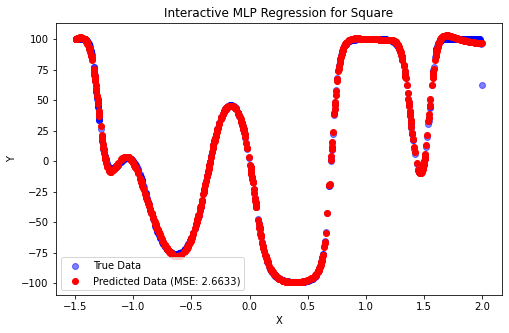

In [53]:
plt.figure(figsize=(8, 5))
plt.scatter(X_multimodalL_test, Y_multimodalL_test, label='True Data', color='blue', alpha=0.5)
plt.scatter(X_multimodalL_test, Ypred, label=f'Predicted Data (MSE: {mse_value:.4f})', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interactive MLP Regression for Square')
plt.show()

# now lets move on to additional testing on step-large and rings5-regular and ring3-regular

stepsL and rings3-regular are already loaded a normalized.  
X_stepsL_train_normalized = (X_stepsL_train- np.mean(X_stepsL_train))/(np.std(X_stepsL_train))
Y_stepsL_train_normalized =(Y_stepsL_train - np.mean(Y_stepsL_train))/(np.std(Y_stepsL_train))
X_stepsL_test_normalized = (X_stepsL_test - np.mean(X_stepsL_train))/(np.std(X_stepsL_train))
Y_stepsL_test_normalized =(Y_stepsL_test - np.mean(Y_stepsL_train))/(np.std(Y_stepsL_train)) 

X_ringsR_train = np.array(df_ringsR_train[['x', 'y']])  
Y_ringsR_train = np.array(df_ringsR_train[['c']])  
X_ringsR_test = np.array(df_ringsR_test[['x', 'y']])  
Y_ringsR_test = np.array(df_ringsR_test[['c']])  
X_ringsR_train_normalized = (X_ringsR_train - np.mean(X_ringsR_train))/np.std(X_ringsR_train)  
X_ringsR_test_normalized = (X_ringsR_test - np.mean(X_ringsR_train))/np.std(X_ringsR_train)    

Lets load ring5

In [47]:
df_ringsR5_train = pd.read_csv('rings5-regular-training.csv')
df_ringsR5_test = pd.read_csv('rings5-regular-test.csv')


In [48]:
df_ringsR5_train.head()

,x,y,c
0,26.926121,-16.588451,0
1,-77.438767,95.159464,0
2,-98.650099,94.923714,0
3,22.241184,-5.447678,0
4,12.843637,-21.496457,0


In [49]:
X_ringsR5_train = np.array(df_ringsR5_train[['x', 'y']])  
Y_ringsR5_train = np.array(df_ringsR5_train[['c']])  
X_ringsR5_test = np.array(df_ringsR5_test[['x', 'y']])  
Y_ringsR5_test = np.array(df_ringsR5_test[['c']]) 

In [50]:
X_ringsR5_train_normalized = (X_ringsR5_train - np.mean(X_ringsR5_train))/np.std(X_ringsR5_train)  
X_ringsR5_test_normalized = (X_ringsR5_test - np.mean(X_ringsR5_train))/np.std(X_ringsR5_train) 

## stepsLarge


lets test in on one hidden layer

In [54]:
activation_functions =['sigmoid', 'linear', 'tanh', 'relu']
num_neurons = [5, 10, 15, 20]

for hidden_function in activation_functions:
    for output_function in activation_functions:
        if hidden_function == output_function:
            continue
        for neurons in num_neurons:
            mlp_stepsL = MLPNoBackprop(layer_sizes = [1, neurons, 1], hidden_activation=hidden_function, output_activation=output_function)
            start_time = time.time()
            mlp_stepsL.mini_batch_GD(X_stepsL_train_normalized,Y_stepsL_train_normalized , epochs = 1000, learning_rate = 0.01, batch_size=64)
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"""Execution time: {execution_time:.6f} seconds
            for one layer with {hidden_function} hidden activation and {output_function} output activation
            one layer with {neurons} neurons""")
            Ypred_normalized = mlp_stepsL.predict(X_stepsL_test_normalized)
            Ypred = (Ypred_normalized * np.std(Y_stepsL_train_normalized)) + np.mean(Y_stepsL_train_normalized)
            print('mse:')
            print(mlp_stepsL.mse(Ypred, Y_stepsL_test))
            print('--------------------------------------------------------------------------------')

Execution time: 37.009719 seconds
            for one layer with sigmoid hidden activation and linear output activation
            one layer with 5 neurons
mse:
7302.438220727504
--------------------------------------------------------------------------------
Execution time: 41.592634 seconds
            for one layer with sigmoid hidden activation and linear output activation
            one layer with 10 neurons
mse:
7301.556950814843
--------------------------------------------------------------------------------
Execution time: 42.604982 seconds
            for one layer with sigmoid hidden activation and linear output activation
            one layer with 15 neurons
mse:
7302.4268297343
--------------------------------------------------------------------------------
Execution time: 46.742369 seconds
            for one layer with sigmoid hidden activation and linear output activation
            one layer with 20 neurons
mse:
7301.789860376223
------------------------------------

Execution time: 11.726496 seconds
            for one layer with tanh hidden activation and relu output activation
            one layer with 5 neurons
mse:
7352.44870299836
--------------------------------------------------------------------------------
Execution time: 13.157080 seconds
            for one layer with tanh hidden activation and relu output activation
            one layer with 10 neurons
mse:
7353.383112641035
--------------------------------------------------------------------------------
Execution time: 14.855235 seconds
            for one layer with tanh hidden activation and relu output activation
            one layer with 15 neurons
mse:
7353.220439348105
--------------------------------------------------------------------------------
Execution time: 16.414217 seconds
            for one layer with tanh hidden activation and relu output activation
            one layer with 20 neurons
mse:
7353.072177128797
-------------------------------------------------------

### dalsze testy na większej ilości epok dla 3 najlepszych par funkcji 

In [59]:
activation_functions =[['sigmoid', 'linear'], ['tanh', 'linear'], ['relu', 'linear']]
num_neurons = [10, 15, 20, 25]

for el in activation_functions:
    for neurons in num_neurons:
            mlp_stepsL = MLPNoBackprop(layer_sizes = [1, neurons, 1], hidden_activation = el[0], output_activation = el[1])
            start_time = time.time()
            mlp_stepsL.mini_batch_GD(X_stepsL_train_normalized,Y_stepsL_train_normalized , epochs = 5000, learning_rate = 0.05, batch_size=64)
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"""Execution time: {execution_time:.6f} seconds
            for one layer with {el[0]} hidden activation and {el[1]} output activation
            one layer with {neurons} neurons""")
            Ypred_normalized = mlp_stepsL.predict(X_stepsL_test_normalized)
            Ypred = (Ypred_normalized * np.std(Y_stepsL_train_normalized)) + np.mean(Y_stepsL_train_normalized)
            print('mse:')
            print(mlp_stepsL.mse(Ypred, Y_stepsL_test))
            print('--------------------------------------------------------------------------------')
        

Execution time: 65.576581 seconds
            for one layer with sigmoid hidden activation and linear output activation
            one layer with 10 neurons
mse:
7292.0775721280925
--------------------------------------------------------------------------------
Execution time: 66.860545 seconds
            for one layer with sigmoid hidden activation and linear output activation
            one layer with 15 neurons
mse:
7294.113757896469
--------------------------------------------------------------------------------
Execution time: 73.373752 seconds
            for one layer with sigmoid hidden activation and linear output activation
            one layer with 20 neurons
mse:
7297.369598197659
--------------------------------------------------------------------------------
Execution time: 84.676295 seconds
            for one layer with sigmoid hidden activation and linear output activation
            one layer with 25 neurons
mse:
7297.207003175
-----------------------------------

tanh and linear seems the best

In [81]:
mlp_stepsL = MLPNoBackprop(layer_sizes = [1, 6, 6, 1], hidden_activation = 'tanh', output_activation = 'linear')
start_time = time.time()
mlp_stepsL.mini_batch_GD(X_stepsL_train_normalized,Y_stepsL_train_normalized , epochs = 1000, learning_rate = 0.001, batch_size=64)
end_time = time.time()
execution_time = end_time - start_time
Ypred_normalized = mlp_stepsL.predict(X_stepsL_test_normalized)
Ypred = (Ypred_normalized * np.std(Y_stepsL_train_normalized)) + np.mean(Y_stepsL_train_normalized)
print('mse:')
print(mlp_stepsL.mse(Ypred, Y_stepsL_test))
print('--------------------------------------------------------------------------------')

Epoka 0: Loss = 1.649514118
Epoka 10: Loss = 1.420651906
Epoka 20: Loss = 1.388463435
Epoka 30: Loss = 1.362160155
Epoka 40: Loss = 1.342018226
Epoka 50: Loss = 1.325254574
Epoka 60: Loss = 1.309956604
Epoka 70: Loss = 1.297049848
Epoka 80: Loss = 1.286197924
Epoka 90: Loss = 1.278763383
Epoka 100: Loss = 1.266834194
Epoka 110: Loss = 1.263989856
Epoka 120: Loss = 1.255354675
Epoka 130: Loss = 1.247458000
Epoka 140: Loss = 1.245196018
Epoka 150: Loss = 1.240658921
Epoka 160: Loss = 1.237764573
Epoka 170: Loss = 1.232415432
Epoka 180: Loss = 1.227446683
Epoka 190: Loss = 1.233429340
Epoka 200: Loss = 1.222805689
Epoka 210: Loss = 1.221602680
Epoka 220: Loss = 1.221766837
Epoka 230: Loss = 1.217913079
Epoka 240: Loss = 1.217460046
Epoka 250: Loss = 1.214243330
Epoka 260: Loss = 1.208968750
Epoka 270: Loss = 1.205120803
Epoka 280: Loss = 1.211090280
Epoka 290: Loss = 1.206385692
Epoka 300: Loss = 1.207040220
Epoka 310: Loss = 1.202323790
Epoka 320: Loss = 1.202562732
Epoka 330: Loss = 1.2

## Rings3-Regular
będę testować rózne funkcje aktywacji w warstwie ukrytej, w output pozostaje softmax


In [87]:
activation_functions =['sigmoid', 'linear', 'tanh', 'relu']
num_neurons = [5, 10, 15, 20]
for el in activation_functions:
    for neurons in num_neurons:
        mlp_ringsR = MLPNoBackprop(layer_sizes = [X_ringsR_train.shape[1], neurons, len(np.unique(Y_ringsR_train))], 
                                   output_activation='softmax', hidden_activation = el)
        start_time = time.time()
        mlp_ringsR.classifiaction_train(X_ringsR_train_normalized, Y_ringsR_train, epochs = 1000, learning_rate=0.01, batch_size=10)
        end_time = time.time()
        execution_time = end_time - start_time
        print('--------------------------------------------------------------------------------------------')
        print(f"Czas wykonania: {execution_time:.6f} sekundy dla {el} w warstwie ukrytej i {neurons} neuronów")
        ypred = mlp_ringsR.predict_classification(X_ringsR_test_normalized)
        print('f1 score:')
        print(mlp_ringsR.f1_score(Y_ringsR_test, ypred))
        print('--------------------------------------------------------------------------------------------')


Epoka 0: Loss = 0.325316030
Epoka 10: Loss = 0.438041431
Epoka 20: Loss = 0.434231987
Epoka 30: Loss = 0.537188154
Epoka 40: Loss = 0.618863268
Epoka 50: Loss = 0.677081301
Epoka 60: Loss = 0.705475452
Epoka 70: Loss = 0.741406690
Epoka 80: Loss = 0.732148083
Epoka 90: Loss = 0.764778032
Epoka 100: Loss = 0.766476618
Epoka 110: Loss = 0.812211121
Epoka 120: Loss = 0.828766769
Epoka 130: Loss = 0.859876662
Epoka 140: Loss = 0.871527343
Epoka 150: Loss = 0.836352188
Epoka 160: Loss = 0.872765171
Epoka 170: Loss = 0.867900375
Epoka 180: Loss = 0.882727617
Epoka 190: Loss = 0.875086590
Epoka 200: Loss = 0.869732327
Epoka 210: Loss = 0.872215915
Epoka 220: Loss = 0.878452458
Epoka 230: Loss = 0.882003372
Epoka 240: Loss = 0.879794647
Epoka 250: Loss = 0.883919536
Epoka 260: Loss = 0.881385387
Epoka 270: Loss = 0.889949111
Epoka 280: Loss = 0.876982466
Epoka 290: Loss = 0.879758183
Epoka 300: Loss = 0.882615564
Epoka 310: Loss = 0.879896718
Epoka 320: Loss = 0.886635116
Epoka 330: Loss = 0.8

Epoka 560: Loss = 0.954635647
Epoka 570: Loss = 0.951965618
Epoka 580: Loss = 0.955971449
Epoka 590: Loss = 0.953267785
Epoka 600: Loss = 0.959308843
Epoka 610: Loss = 0.955904953
Epoka 620: Loss = 0.963276282
Epoka 630: Loss = 0.966005372
Epoka 640: Loss = 0.960631398
Epoka 650: Loss = 0.964666017
Epoka 660: Loss = 0.955939479
Epoka 670: Loss = 0.965992683
Epoka 680: Loss = 0.961969292
Epoka 690: Loss = 0.964647650
Epoka 700: Loss = 0.967325073
Epoka 710: Loss = 0.968011494
Epoka 720: Loss = 0.965990555
Epoka 730: Loss = 0.967361887
Epoka 740: Loss = 0.965395393
Epoka 750: Loss = 0.963999329
Epoka 760: Loss = 0.967957954
Epoka 770: Loss = 0.967369405
Epoka 780: Loss = 0.971361150
Epoka 790: Loss = 0.964593498
Epoka 800: Loss = 0.966630483
Epoka 810: Loss = 0.966662498
Epoka 820: Loss = 0.970661980
Epoka 830: Loss = 0.966038403
Epoka 840: Loss = 0.968104306
Epoka 850: Loss = 0.971373127
Epoka 860: Loss = 0.970016773
Epoka 870: Loss = 0.971353717
Epoka 880: Loss = 0.973342482
Epoka 890:

Epoka 20: Loss = 0.380720908
Epoka 30: Loss = 0.359070991
Epoka 40: Loss = 0.423781372
Epoka 50: Loss = 0.437063122
Epoka 60: Loss = 0.445602979
Epoka 70: Loss = 0.357689059
Epoka 80: Loss = 0.429186392
Epoka 90: Loss = 0.428721500
Epoka 100: Loss = 0.354815554
Epoka 110: Loss = 0.448357262
Epoka 120: Loss = 0.404734225
Epoka 130: Loss = 0.348807519
Epoka 140: Loss = 0.357201300
Epoka 150: Loss = 0.338915419
Epoka 160: Loss = 0.350873713
Epoka 170: Loss = 0.506391358
Epoka 180: Loss = 0.388574869
Epoka 190: Loss = 0.384518214
Epoka 200: Loss = 0.458424869
Epoka 210: Loss = 0.367603456
Epoka 220: Loss = 0.392194074
Epoka 230: Loss = 0.392401680
Epoka 240: Loss = 0.474491133
Epoka 250: Loss = 0.409885121
Epoka 260: Loss = 0.462291787
Epoka 270: Loss = 0.452162979
Epoka 280: Loss = 0.435323482
Epoka 290: Loss = 0.501836136
Epoka 300: Loss = 0.503524207
Epoka 310: Loss = 0.376706584
Epoka 320: Loss = 0.487803506
Epoka 330: Loss = 0.460639801
Epoka 340: Loss = 0.404464332
Epoka 350: Loss = 

Epoka 580: Loss = 0.384925584
Epoka 590: Loss = 0.408589286
Epoka 600: Loss = 0.370609722
Epoka 610: Loss = 0.451457638
Epoka 620: Loss = 0.426557384
Epoka 630: Loss = 0.431859624
Epoka 640: Loss = 0.378163823
Epoka 650: Loss = 0.430311041
Epoka 660: Loss = 0.430805285
Epoka 670: Loss = 0.496696762
Epoka 680: Loss = 0.363091192
Epoka 690: Loss = 0.399223698
Epoka 700: Loss = 0.418345656
Epoka 710: Loss = 0.426472693
Epoka 720: Loss = 0.454061754
Epoka 730: Loss = 0.360242820
Epoka 740: Loss = 0.351278442
Epoka 750: Loss = 0.366339162
Epoka 760: Loss = 0.353587912
Epoka 770: Loss = 0.503786579
Epoka 780: Loss = 0.457578990
Epoka 790: Loss = 0.377352245
Epoka 800: Loss = 0.423066047
Epoka 810: Loss = 0.433695902
Epoka 820: Loss = 0.391770072
Epoka 830: Loss = 0.488731884
Epoka 840: Loss = 0.418378916
Epoka 850: Loss = 0.440350921
Epoka 860: Loss = 0.380627368
Epoka 870: Loss = 0.380839455
Epoka 880: Loss = 0.434604279
Epoka 890: Loss = 0.382086913
Epoka 900: Loss = 0.465860104
Epoka 910:

Epoka 40: Loss = 0.908913334
Epoka 50: Loss = 0.934167163
Epoka 60: Loss = 0.926241518
Epoka 70: Loss = 0.912151437
Epoka 80: Loss = 0.941376763
Epoka 90: Loss = 0.937783460
Epoka 100: Loss = 0.933427087
Epoka 110: Loss = 0.946580093
Epoka 120: Loss = 0.935033624
Epoka 130: Loss = 0.954014028
Epoka 140: Loss = 0.959326339
Epoka 150: Loss = 0.952594394
Epoka 160: Loss = 0.963997599
Epoka 170: Loss = 0.960086387
Epoka 180: Loss = 0.964628618
Epoka 190: Loss = 0.961907779
Epoka 200: Loss = 0.958078817
Epoka 210: Loss = 0.957877550
Epoka 220: Loss = 0.966675715
Epoka 230: Loss = 0.971969770
Epoka 240: Loss = 0.958732480
Epoka 250: Loss = 0.959243493
Epoka 260: Loss = 0.970009434
Epoka 270: Loss = 0.959228011
Epoka 280: Loss = 0.973348807
Epoka 290: Loss = 0.970665526
Epoka 300: Loss = 0.967371313
Epoka 310: Loss = 0.957285390
Epoka 320: Loss = 0.965401226
Epoka 330: Loss = 0.961378331
Epoka 340: Loss = 0.953035437
Epoka 350: Loss = 0.968734390
Epoka 360: Loss = 0.974689856
Epoka 370: Loss 

Epoka 600: Loss = 0.778290504
Epoka 610: Loss = 0.765893593
Epoka 620: Loss = 0.740068646
Epoka 630: Loss = 0.779541072
Epoka 640: Loss = 0.760347103
Epoka 650: Loss = 0.767065041
Epoka 660: Loss = 0.757625064
Epoka 670: Loss = 0.765889023
Epoka 680: Loss = 0.749657440
Epoka 690: Loss = 0.760206196
Epoka 700: Loss = 0.759413917
Epoka 710: Loss = 0.780131310
Epoka 720: Loss = 0.736095452
Epoka 730: Loss = 0.756619702
Epoka 740: Loss = 0.770295490
Epoka 750: Loss = 0.767161662
Epoka 760: Loss = 0.774096158
Epoka 770: Loss = 0.765877078
Epoka 780: Loss = 0.752137122
Epoka 790: Loss = 0.777262674
Epoka 800: Loss = 0.764392560
Epoka 810: Loss = 0.767642068
Epoka 820: Loss = 0.779192733
Epoka 830: Loss = 0.777702474
Epoka 840: Loss = 0.756956485
Epoka 850: Loss = 0.774853360
Epoka 860: Loss = 0.770443245
Epoka 870: Loss = 0.756618249
Epoka 880: Loss = 0.752008168
Epoka 890: Loss = 0.769936788
Epoka 900: Loss = 0.761628885
Epoka 910: Loss = 0.773199239
Epoka 920: Loss = 0.770429392
Epoka 930:

Epoka 80: Loss = 0.919229217
Epoka 90: Loss = 0.928819533
Epoka 100: Loss = 0.901539152
Epoka 110: Loss = 0.932672617
Epoka 120: Loss = 0.930852166
Epoka 130: Loss = 0.894338214
Epoka 140: Loss = 0.930897581
Epoka 150: Loss = 0.928491707
Epoka 160: Loss = 0.923122525
Epoka 170: Loss = 0.919864374
Epoka 180: Loss = 0.930678139
Epoka 190: Loss = 0.900613557
Epoka 200: Loss = 0.938979842
Epoka 210: Loss = 0.925636659
Epoka 220: Loss = 0.891455546
Epoka 230: Loss = 0.913089428
Epoka 240: Loss = 0.902817982
Epoka 250: Loss = 0.941366454
Epoka 260: Loss = 0.851325059
Epoka 270: Loss = 0.947345910
Epoka 280: Loss = 0.959987553
Epoka 290: Loss = 0.928816032
Epoka 300: Loss = 0.950510612
Epoka 310: Loss = 0.938268348
Epoka 320: Loss = 0.947976899
Epoka 330: Loss = 0.951978529
Epoka 340: Loss = 0.918520906
Epoka 350: Loss = 0.921508256
Epoka 360: Loss = 0.942252139
Epoka 370: Loss = 0.958627662
Epoka 380: Loss = 0.930293012
Epoka 390: Loss = 0.853419703
Epoka 400: Loss = 0.912782615
Epoka 410: L

 najlepiej pordział sobie tanh, sigmoid, relu tez wypada nie najgorzej, najgorzej linear

## Rings5-regular

In [89]:
activation_functions =['sigmoid', 'linear', 'tanh', 'relu']
num_neurons = [5, 10, 15, 20]
for el in activation_functions:
    for neurons in num_neurons:
        mlp_ringsR = MLPNoBackprop(layer_sizes = [X_ringsR5_train.shape[1], neurons, len(np.unique(Y_ringsR5_train))], 
                                   output_activation='softmax', hidden_activation = el)
        start_time = time.time()
        mlp_ringsR.classifiaction_train(X_ringsR5_train_normalized, Y_ringsR5_train, epochs = 1000, learning_rate=0.01, batch_size=10)
        end_time = time.time()
        execution_time = end_time - start_time
        print('--------------------------------------------------------------------------------------------')
        print(f"Czas wykonania: {execution_time:.6f} sekundy dla {el} w warstwie ukrytej i {neurons} neuronów")
        ypred = mlp_ringsR.predict_classification(X_ringsR5_test_normalized)
        print('f1 score:')
        print(mlp_ringsR.f1_score(Y_ringsR5_test, ypred))
        print('--------------------------------------------------------------------------------------------')


Epoka 0: Loss = 0.210162206
Epoka 10: Loss = 0.305835164
Epoka 20: Loss = 0.394082362
Epoka 30: Loss = 0.562739107
Epoka 40: Loss = 0.497999253
Epoka 50: Loss = 0.481666138
Epoka 60: Loss = 0.570567539
Epoka 70: Loss = 0.665527401
Epoka 80: Loss = 0.666709396
Epoka 90: Loss = 0.654296339
Epoka 100: Loss = 0.690149529
Epoka 110: Loss = 0.692357182
Epoka 120: Loss = 0.698592685
Epoka 130: Loss = 0.691198487
Epoka 140: Loss = 0.708581158
Epoka 150: Loss = 0.703337484
Epoka 160: Loss = 0.703756433
Epoka 170: Loss = 0.698410095
Epoka 180: Loss = 0.708805933
Epoka 190: Loss = 0.706997884
Epoka 200: Loss = 0.715938503
Epoka 210: Loss = 0.710910710
Epoka 220: Loss = 0.717891493
Epoka 230: Loss = 0.715382930
Epoka 240: Loss = 0.724840199
Epoka 250: Loss = 0.719167885
Epoka 260: Loss = 0.712473757
Epoka 270: Loss = 0.717422628
Epoka 280: Loss = 0.729631283
Epoka 290: Loss = 0.723472570
Epoka 300: Loss = 0.727757871
Epoka 310: Loss = 0.731403966
Epoka 320: Loss = 0.728956009
Epoka 330: Loss = 0.7

Epoka 550: Loss = 0.918147194
Epoka 560: Loss = 0.920622079
Epoka 570: Loss = 0.920560335
Epoka 580: Loss = 0.922283428
Epoka 590: Loss = 0.918798766
Epoka 600: Loss = 0.918717162
Epoka 610: Loss = 0.925522768
Epoka 620: Loss = 0.924493931
Epoka 630: Loss = 0.918952047
Epoka 640: Loss = 0.926268589
Epoka 650: Loss = 0.921410658
Epoka 660: Loss = 0.927821356
Epoka 670: Loss = 0.926824841
Epoka 680: Loss = 0.926929321
Epoka 690: Loss = 0.929473053
Epoka 700: Loss = 0.930255042
Epoka 710: Loss = 0.931774433
Epoka 720: Loss = 0.933516492
Epoka 730: Loss = 0.934112397
Epoka 740: Loss = 0.931108978
Epoka 750: Loss = 0.930119936
Epoka 760: Loss = 0.935196345
Epoka 770: Loss = 0.933428412
Epoka 780: Loss = 0.931876234
Epoka 790: Loss = 0.935895965
Epoka 800: Loss = 0.934366190
Epoka 810: Loss = 0.934967261
Epoka 820: Loss = 0.935943920
Epoka 830: Loss = 0.939827484
Epoka 840: Loss = 0.932553843
Epoka 850: Loss = 0.937389083
Epoka 860: Loss = 0.935032401
Epoka 870: Loss = 0.938200794
Epoka 880:

Epoka 20: Loss = 0.298498173
Epoka 30: Loss = 0.288298166
Epoka 40: Loss = 0.267627508
Epoka 50: Loss = 0.320464108
Epoka 60: Loss = 0.329552809
Epoka 70: Loss = 0.294482866
Epoka 80: Loss = 0.288761580
Epoka 90: Loss = 0.306756265
Epoka 100: Loss = 0.332353302
Epoka 110: Loss = 0.315068240
Epoka 120: Loss = 0.274103928
Epoka 130: Loss = 0.325874690
Epoka 140: Loss = 0.311914235
Epoka 150: Loss = 0.299706247
Epoka 160: Loss = 0.288378020
Epoka 170: Loss = 0.281311267
Epoka 180: Loss = 0.311231219
Epoka 190: Loss = 0.242737566
Epoka 200: Loss = 0.248550935
Epoka 210: Loss = 0.246265086
Epoka 220: Loss = 0.303709970
Epoka 230: Loss = 0.301303567
Epoka 240: Loss = 0.279203249
Epoka 250: Loss = 0.315677193
Epoka 260: Loss = 0.315932415
Epoka 270: Loss = 0.320371527
Epoka 280: Loss = 0.289592344
Epoka 290: Loss = 0.251603488
Epoka 300: Loss = 0.309452372
Epoka 310: Loss = 0.314191294
Epoka 320: Loss = 0.234898542
Epoka 330: Loss = 0.269543103
Epoka 340: Loss = 0.281381763
Epoka 350: Loss = 

Epoka 600: Loss = 0.264899738
Epoka 610: Loss = 0.267957769
Epoka 620: Loss = 0.290458037
Epoka 630: Loss = 0.324903035
Epoka 640: Loss = 0.276385174
Epoka 650: Loss = 0.279645045
Epoka 660: Loss = 0.303455008
Epoka 670: Loss = 0.259067015
Epoka 680: Loss = 0.293046181
Epoka 690: Loss = 0.300889661
Epoka 700: Loss = 0.243567076
Epoka 710: Loss = 0.281292335
Epoka 720: Loss = 0.313036825
Epoka 730: Loss = 0.301339421
Epoka 740: Loss = 0.275308134
Epoka 750: Loss = 0.311688813
Epoka 760: Loss = 0.284130183
Epoka 770: Loss = 0.297481864
Epoka 780: Loss = 0.316952434
Epoka 790: Loss = 0.294803106
Epoka 800: Loss = 0.311886079
Epoka 810: Loss = 0.289254188
Epoka 820: Loss = 0.287242955
Epoka 830: Loss = 0.297823594
Epoka 840: Loss = 0.269098168
Epoka 850: Loss = 0.283425048
Epoka 860: Loss = 0.308681001
Epoka 870: Loss = 0.302183395
Epoka 880: Loss = 0.303774884
Epoka 890: Loss = 0.311836898
Epoka 900: Loss = 0.284895626
Epoka 910: Loss = 0.299282068
Epoka 920: Loss = 0.270403153
Epoka 930:

Epoka 60: Loss = 0.899750598
Epoka 70: Loss = 0.892317332
Epoka 80: Loss = 0.906758011
Epoka 90: Loss = 0.913121538
Epoka 100: Loss = 0.924073653
Epoka 110: Loss = 0.920126587
Epoka 120: Loss = 0.928502787
Epoka 130: Loss = 0.928687850
Epoka 140: Loss = 0.933949684
Epoka 150: Loss = 0.937818477
Epoka 160: Loss = 0.938312097
Epoka 170: Loss = 0.937372822
Epoka 180: Loss = 0.941374378
Epoka 190: Loss = 0.940400858
Epoka 200: Loss = 0.946234654
Epoka 210: Loss = 0.946317149
Epoka 220: Loss = 0.946981881
Epoka 230: Loss = 0.923757449
Epoka 240: Loss = 0.947048106
Epoka 250: Loss = 0.955961075
Epoka 260: Loss = 0.950213325
Epoka 270: Loss = 0.957632822
Epoka 280: Loss = 0.961647290
Epoka 290: Loss = 0.952620809
Epoka 300: Loss = 0.960746537
Epoka 310: Loss = 0.951923305
Epoka 320: Loss = 0.959138028
Epoka 330: Loss = 0.956016407
Epoka 340: Loss = 0.967982012
Epoka 350: Loss = 0.960566520
Epoka 360: Loss = 0.960772477
Epoka 370: Loss = 0.965526436
Epoka 380: Loss = 0.959998304
Epoka 390: Los

Epoka 630: Loss = 0.767910327
Epoka 640: Loss = 0.788805983
Epoka 650: Loss = 0.734214671
Epoka 660: Loss = 0.793032165
Epoka 670: Loss = 0.792138061
Epoka 680: Loss = 0.785650590
Epoka 690: Loss = 0.800810324
Epoka 700: Loss = 0.799630346
Epoka 710: Loss = 0.777482941
Epoka 720: Loss = 0.779630221
Epoka 730: Loss = 0.801980747
Epoka 740: Loss = 0.794358841
Epoka 750: Loss = 0.759454760
Epoka 760: Loss = 0.808759282
Epoka 770: Loss = 0.792977672
Epoka 780: Loss = 0.793631160
Epoka 790: Loss = 0.794520143
Epoka 800: Loss = 0.780880942
Epoka 810: Loss = 0.799978439
Epoka 820: Loss = 0.805588270
Epoka 830: Loss = 0.797909071
Epoka 840: Loss = 0.784509122
Epoka 850: Loss = 0.789342487
Epoka 860: Loss = 0.782006428
Epoka 870: Loss = 0.779422291
Epoka 880: Loss = 0.797786283
Epoka 890: Loss = 0.771782876
Epoka 900: Loss = 0.789924714
Epoka 910: Loss = 0.779833699
Epoka 920: Loss = 0.794420150
Epoka 930: Loss = 0.794649106
Epoka 940: Loss = 0.782207748
Epoka 950: Loss = 0.777079873
Epoka 960:

Epoka 100: Loss = 0.897670664
Epoka 110: Loss = 0.891148528
Epoka 120: Loss = 0.883763013
Epoka 130: Loss = 0.887653322
Epoka 140: Loss = 0.910244061
Epoka 150: Loss = 0.912813695
Epoka 160: Loss = 0.872394492
Epoka 170: Loss = 0.896018148
Epoka 180: Loss = 0.868681694
Epoka 190: Loss = 0.898573841
Epoka 200: Loss = 0.891089009
Epoka 210: Loss = 0.859318826
Epoka 220: Loss = 0.878964979
Epoka 230: Loss = 0.874180290
Epoka 240: Loss = 0.884414667
Epoka 250: Loss = 0.830923408
Epoka 260: Loss = 0.904462166
Epoka 270: Loss = 0.874789416
Epoka 280: Loss = 0.890748853
Epoka 290: Loss = 0.825879236
Epoka 300: Loss = 0.886824833
Epoka 310: Loss = 0.903990624
Epoka 320: Loss = 0.891271564
Epoka 330: Loss = 0.902256275
Epoka 340: Loss = 0.866569427
Epoka 350: Loss = 0.891022300
Epoka 360: Loss = 0.884657942
Epoka 370: Loss = 0.883549943
Epoka 380: Loss = 0.902688093
Epoka 390: Loss = 0.902123159
Epoka 400: Loss = 0.904279363
Epoka 410: Loss = 0.901922485
Epoka 420: Loss = 0.867741140
Epoka 430:

In [ ]:
najlepiej tanh i 20 neuronów, znów najgorzej linear - wniosek: linear niw n